In [1]:
import numpy as np
from numpy import expand_dims
from numpy import hstack
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
import keras.backend as K
import time
from keras.models import load_model
import os

In [2]:
# https://stackoverflow.com/a/66174336/10945691
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [4]:
def strtime():
    return time.strftime("%Y-%m-%d %H-%M-%S")
strtime()

'2021-04-14 22-50-29'

In [5]:
def get_generator(input_size, ds_shape, kernel_initializer):
    input_latent = layers.Input(shape=(input_size))
    
    image_size = ds_shape[0]
    depth = ds_shape[-1]
    n_nodes = int(128 * image_size / 4 * image_size / 4)

    g = layers.Dense(1024)(input_latent)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)

    g = layers.Dense(n_nodes)(g)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)
    g = layers.Reshape((int(image_size / 4), int(image_size / 4), 128))(g)

    g = layers.Conv2DTranspose(64, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(g)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)

    g = layers.Conv2DTranspose(depth, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(g)
    
    output_layer = layers.Activation('sigmoid')(g)

    gen_model = Model(input_latent, output_layer)
    return gen_model

In [6]:
def get_discriminators(input_shape, kernel_initializer, qcodes, lr):
    input_image=layers.Input(shape=input_shape)

    l=layers.Conv2D(64 , 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(input_image)
    # no batch norm intentionally
    l=layers.LeakyReLU(alpha=0.1)(l)

    l=layers.Conv2D(128, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(l)
    l=layers.BatchNormalization()(l)
    l=layers.LeakyReLU(alpha=0.1)(l)

    l = layers.Dense(1024)(l)
    l = layers.BatchNormalization()(l)
    l = layers.LeakyReLU(alpha=0.1)(l)
    
    l = layers.Flatten()(l)
    
    out=layers.Dense(1, activation='sigmoid')(l)
    discriminator_model = Model(input_image, out)
            
    discriminator_model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=lr, beta_1=0.5))
    q = layers.Dense(128)(l)
    q = layers.BatchNormalization()(q)
    q = layers.LeakyReLU(alpha=0.1)(q)
    q_models = []
    for qdim, qtype in qcodes:
        out_codes = layers.Dense(
            qdim,
            activation='softmax' if qtype == 'categorical' else 'tanh' if qtype == 'continuous' else 'potato'
        )(q)
        q_models += [Model(input_image, out_codes)]
    return discriminator_model, q_models

In [7]:
def get_infogan(G, D, Qs, Qtypes, lr):
    for layer in D.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    discr_output = D(G.output)
    q_outputs = [q(G.output) for q in Qs]
    infogan_model = Model(G.input, [discr_output, *q_outputs])
    opt = Adam(lr=lr, beta_1=0.5)
    Qlosses = [
        'categorical_crossentropy' if qtype == 'categorical' else 'mse' if qtype == 'continuous' else 'potato' for qtype in Qtypes
    ]

    infogan_model.compile(loss = ['binary_crossentropy', *Qlosses], optimizer=opt)
    return infogan_model

In [8]:
def generate_noise_and_codes(n_samples, zdim, qcodes):
    z = np.random.uniform(low = -1, high = 1, size = (n_samples, zdim))
    cat_codes = []
    for qdim, qtype in qcodes:
        if qtype == 'categorical':
            cat_codes += [np.eye(qdim)[np.random.choice(qdim, n_samples)]]
        elif qtype == 'continuous':
            cat_codes += [np.random.uniform(low = -1, high = 1, size = (n_samples, qdim))]
        else:
            raise 1
        z = hstack((z, cat_codes[-1]))
    return z, cat_codes

In [9]:
def generate_fake_samples(G, n_samples, zdim, qcodes):
    z, _ = generate_noise_and_codes(n_samples, zdim, qcodes)
    x = G.predict(z)
    y = np.zeros(n_samples)
    return x, y

In [10]:
class InfoGAN:
    def __init__(
        self,
        dsname = 'mnist',
        qcodes = [(10, 'categorical')],
        latent_dim = 100,
        batch_size = 32,
        stddev = 0.02,
        dlr = 2e-4,
        glr = 1e-3,
    ):
        self.batch_size     = batch_size
        ds                  = self.load(dsname)
        self.ds             = ds[0]
        self.ds_info        = ds[1]
        self.ds_shape       = ds[2]
        self.qcodes         = qcodes
        self.latent_dim     = latent_dim
        self.gen_input_size = self.latent_dim + sum([dim for dim, datatype in self.qcodes])
        self.kernel_init    = RandomNormal(stddev=0.02)
        self.dlr            = dlr
        self.glr            = glr
        self.gen            = get_generator(self.gen_input_size, self.ds_shape, self.kernel_init)
        self.disc, self.qs  = get_discriminators(self.ds_shape, self.kernel_init, self.qcodes, self.dlr)
        self.model = get_infogan(
            self.gen,
            self.disc,
            self.qs,
            [qtype for qdim, qtype in self.qcodes],
            self.glr
        )

    def normalize_img(self, image, _):
        return tf.cast(image, tf.float32) / 255, 1

    def load(self, dsname):
        ds, ds_info = tfds.load(dsname, split='train', with_info=True, as_supervised=True)
        shape = ds_info.features['image'].shape
        ds = ds.map(self.normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache()
        ds = ds.shuffle(ds_info.splits['train'].num_examples)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        return ds, ds_info, shape

    def train(self, n_epochs = 100, steps_per_epoch = None):
        if steps_per_epoch is None:
            steps_per_epoch = len(self.ds)
        n_steps = steps_per_epoch * n_epochs
        for e in range(n_epochs):
            for i in range(steps_per_epoch):
                X_fake, y_fake = generate_fake_samples(self.gen, self.batch_size, self.latent_dim, self.qcodes)
                y_gan = np.ones(self.batch_size)
                z_input, cat_codes = generate_noise_and_codes(self.batch_size, self.latent_dim, self.qcodes)
                realbatch = True
                self.disc.fit(self.ds, steps_per_epoch=1, verbose = 0)
                realbatch = False
                self.disc.fit(X_fake, y_fake, verbose = 0)
                self.model.fit(z_input, [y_gan, *cat_codes], verbose = 0)
                print('\r%d: %d/%d ' % (e + 1, i + 1, steps_per_epoch), end = '')
            print()

In [23]:
def generate_latent_points_from_cat(latent_dim, codes, random=True):
    if random:
        z_latent = np.random.normal(size = (len(codes), latent_dim))
    else:
        z_latent = np.array([np.random.normal(size = (1, latent_dim))] * len(codes)).reshape(len(codes), latent_dim)
    z_input = hstack((z_latent, codes))
    return z_input

def generate_fake_samples_and_z_from_cat(generator, latent_dim, codes, random = True):
    z_input = generate_latent_points_from_cat(latent_dim, codes, random)
    images = generator.predict(z_input)
    return images

def plotSome(gen, latent_dim, codes, grayscale = False, c1 = 10, titleStart = None, random = True):
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, codes, random)
    plt.subplots(figsize=(24, 24))
    for i in range(len(codes)):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(codes[i][:c1]) if titleStart is None else (titleStart + str(np.argmax(codes[i][:c1]))))
        if grayscale:
            plt.imshow(images[i, :, :, 0], cmap='gray_r')
        else:
            plt.imshow(images[i], interpolation='nearest')
    plt.show()

In [16]:
def line(low, high, total, current, minus1 = True):
    diff = high - low
    return low + diff * (current / (total - 1 if minus1 else total))

In [17]:
def mnistTrainPlot(infogan, epochs, steps_per_epoch = None, nrow = 10, name = strtime()):
    ttl = nrow * 10
    for epoch in range(epochs):
        infogan.train(n_epochs=1, steps_per_epoch = steps_per_epoch)
        infogan.gen.save(f'{name} {epoch + 1}.h5')
        c1 = to_categorical([i % 10 for i in range(ttl)], 10)
        c2 = np.array([line(-2, 2, ttl, i) for i in range(ttl)]).reshape(ttl, 1)
        c3 = np.array([line(-2, 2, ttl, i) for i in range(ttl)]).reshape(ttl, 1)
        c = np.hstack((c1, np.hstack((c2, c3))))
        plotSome(infogan.gen, infogan.latent_dim, c, True, titleStart = f'{epoch}: ')

In [60]:
def plotc1(gen, latent_dim=62, ttl=10, seed=14641, titleStart = None):
    np.random.seed(seed)
    c1 = to_categorical([i % 10 for i in range(ttl)], 10)
    c2 = np.array([0 for i in range(ttl)]).reshape(ttl, 1)
    c3 = np.array([0 for i in range(ttl)]).reshape(ttl, 1)
    c = np.hstack((c1, np.hstack((c2, c3))))
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, c, random = False)
    plt.subplots(figsize=(20, 3))
    for i in range(len(c)):
        plt.subplot(1, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(c[i][:10]) if titleStart is None else (titleStart + str(np.argmax(c[i][:10]))))
        plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.show()

def plotc23(gen, latent_dim=62, ttl=10, seed=14641, titleStart = None, c1 = 0, c2 = False, c3 = False):
    np.random.seed(seed)
    c1 = to_categorical([c1 for i in range(ttl)], 10)
    c2 = np.array([line(-2, 2, ttl, i) if c2 else 0 for i in range(ttl)]).reshape(ttl, 1)
    c3 = np.array([line(-2, 2, ttl, i) if c3 else 0 for i in range(ttl)]).reshape(ttl, 1)
    c = np.hstack((c1, np.hstack((c2, c3))))
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, c, random = False)
    plt.subplots(figsize=(20, 3))
    for i in range(len(c)):
        plt.subplot(1, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(c[i][:10]) if titleStart is None else (titleStart + str(np.argmax(c[i][:10]))))
        plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.show()

def plotc3(gen, latent_dim=62, ttl=10, seed=14641, titleStart = None):
    return

1: 100/100 


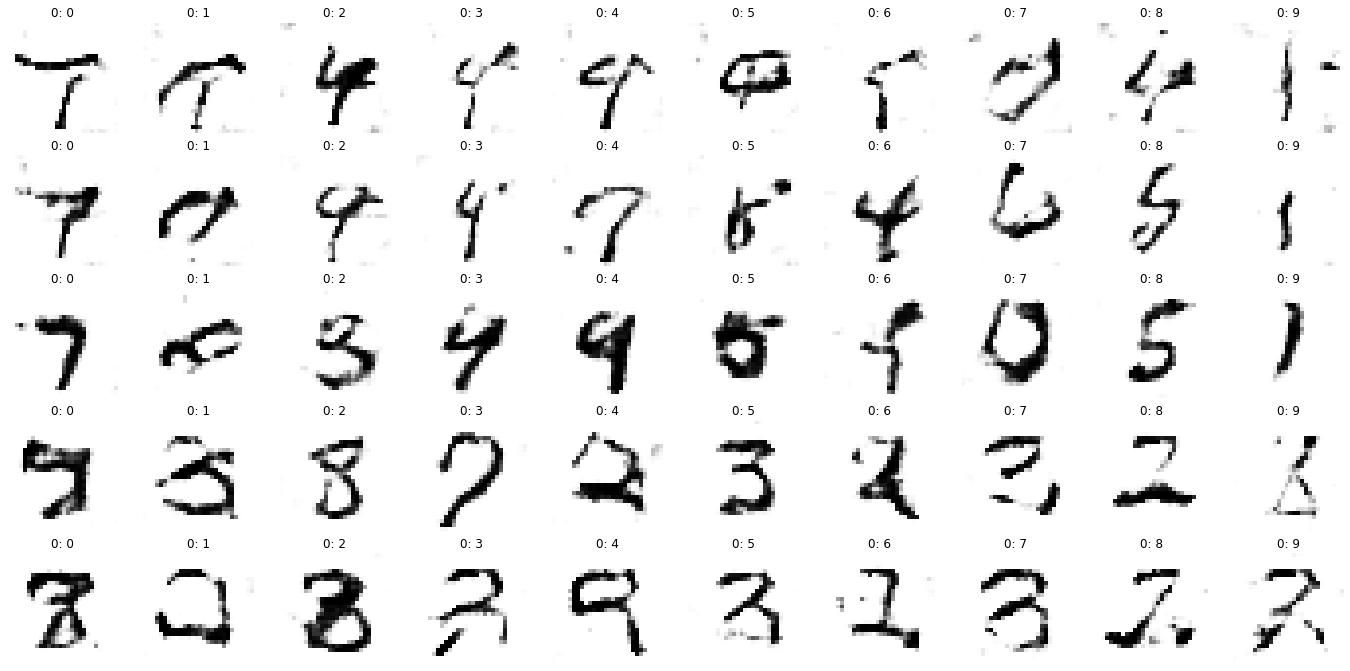

1: 100/100 


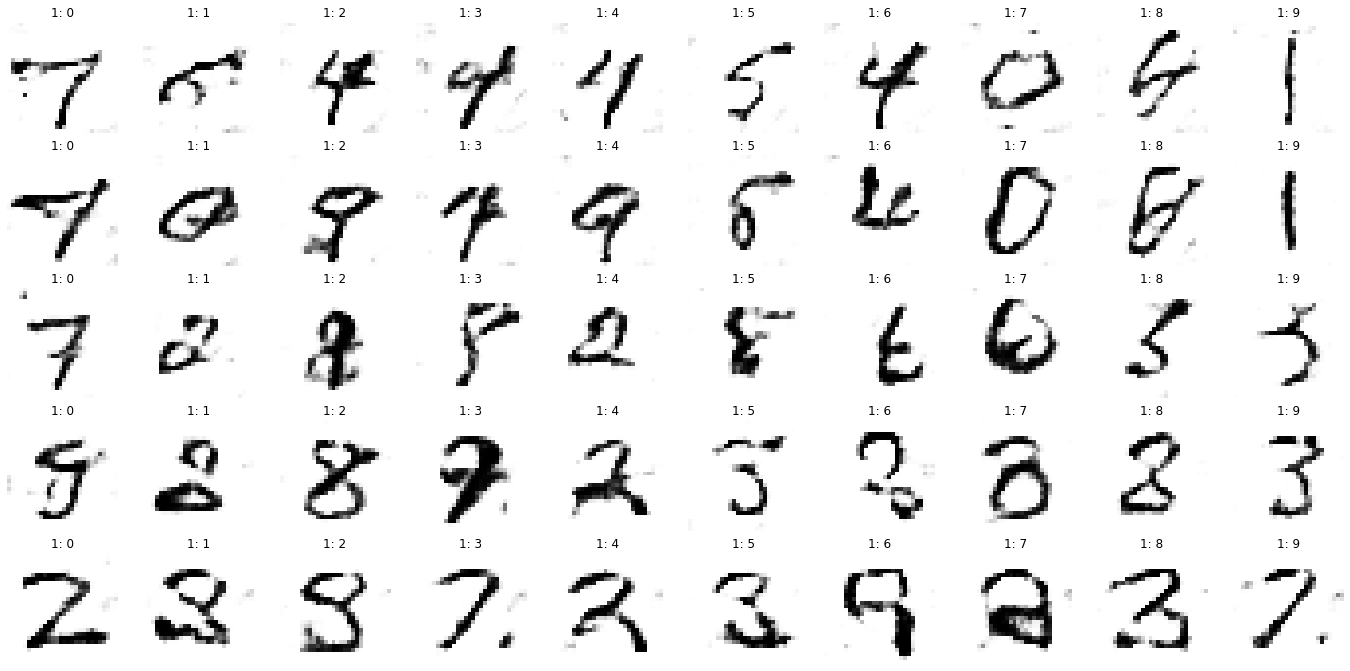

1: 100/100 


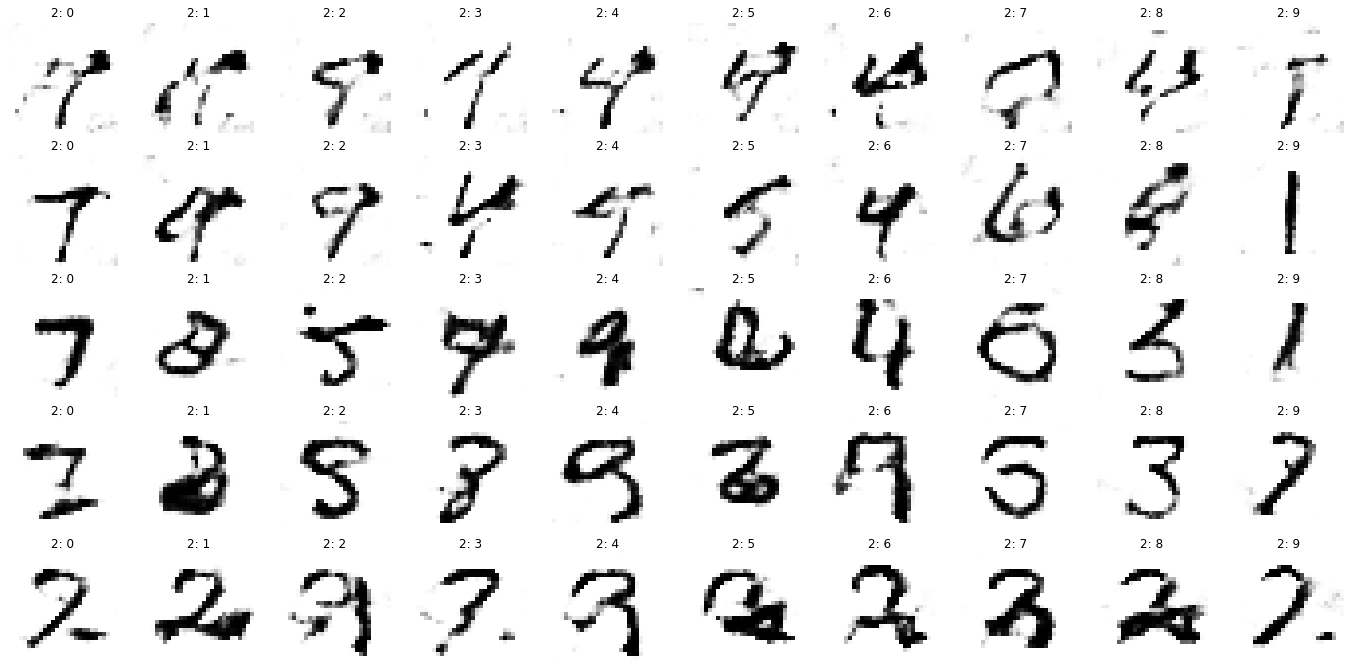

1: 100/100 


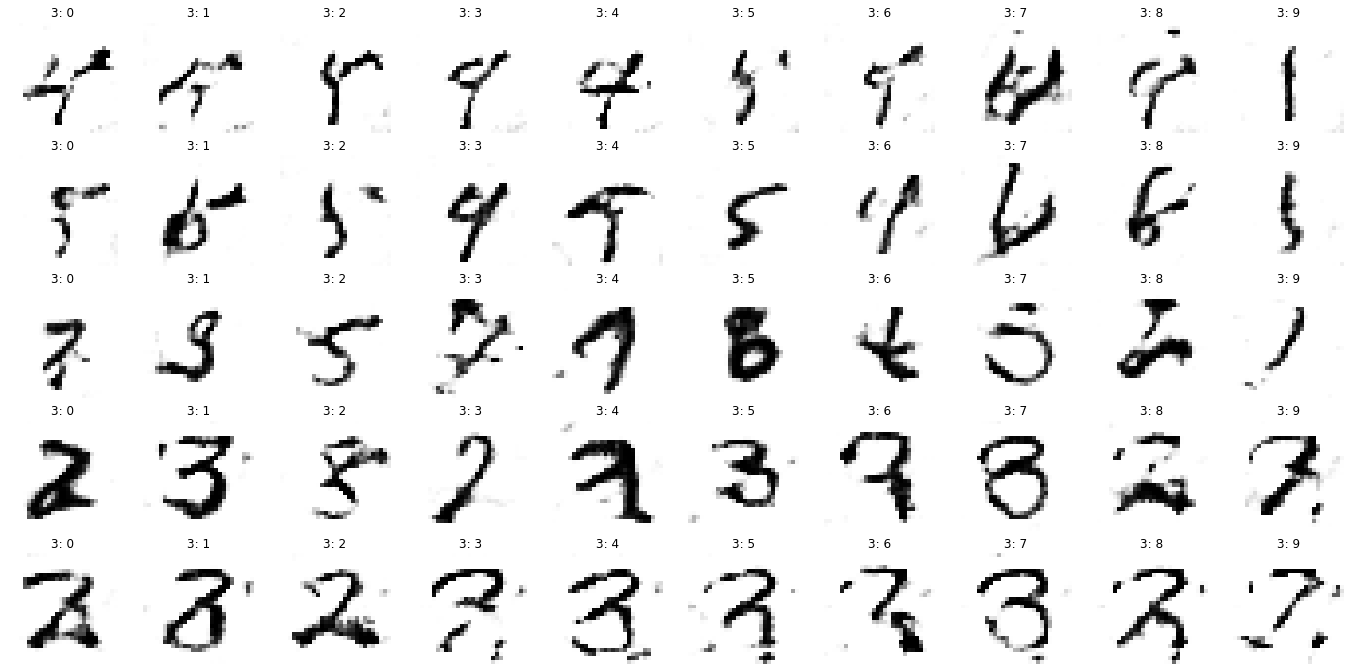

1: 100/100 


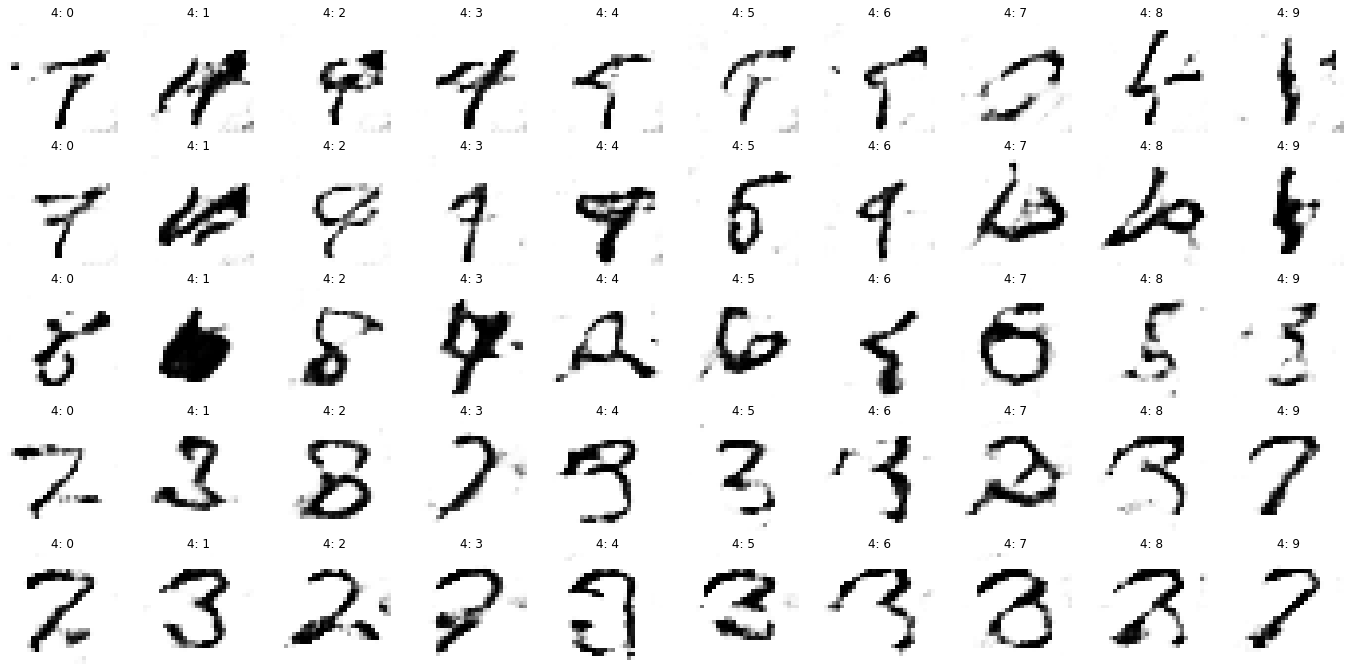

1: 100/100 


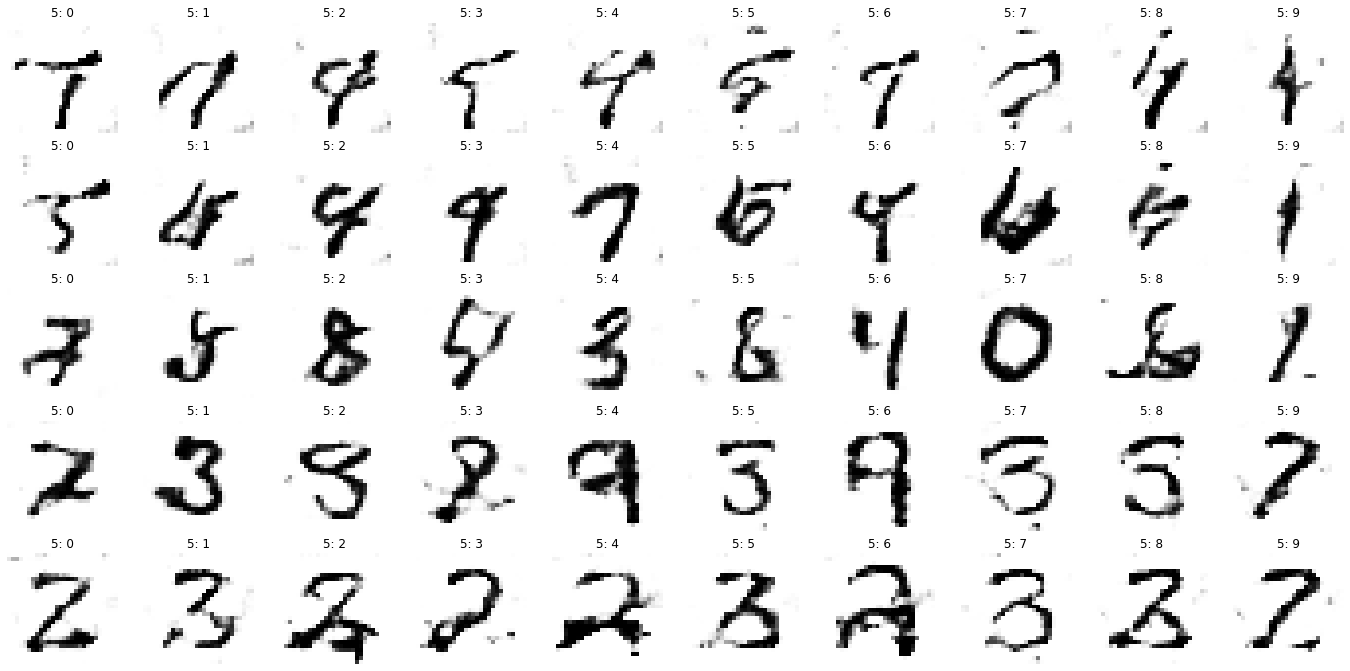

1: 100/100 


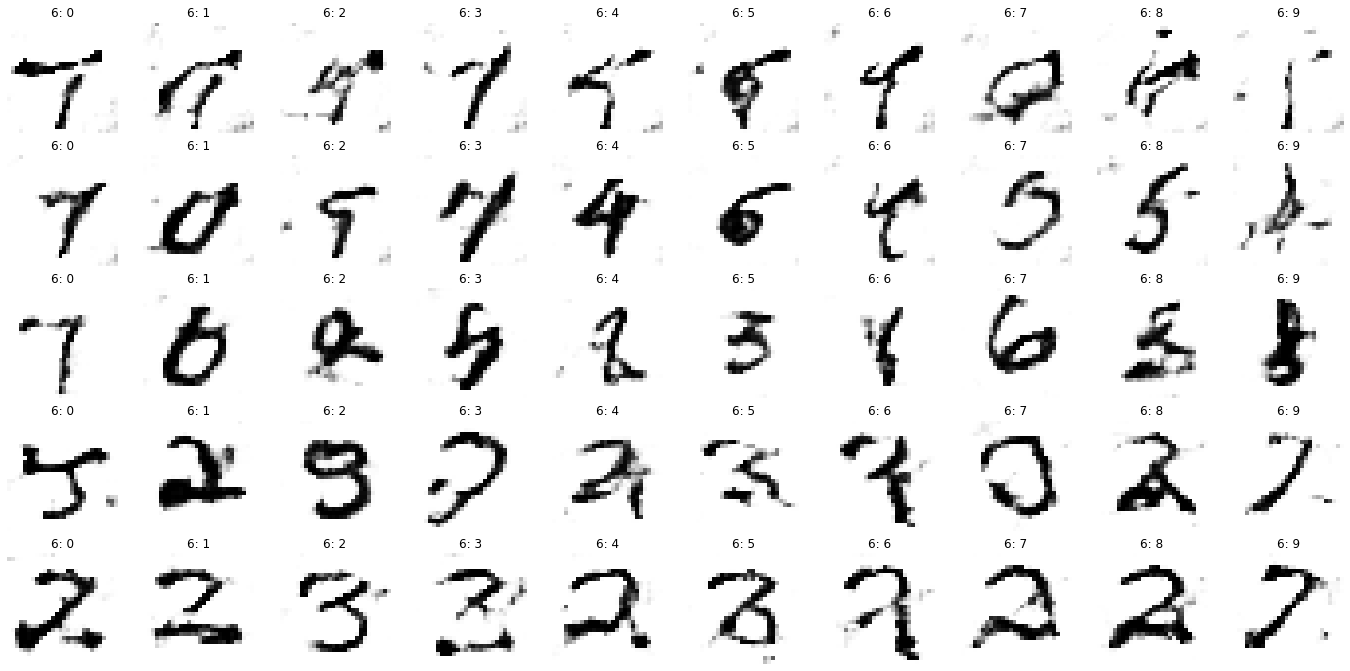

1: 100/100 


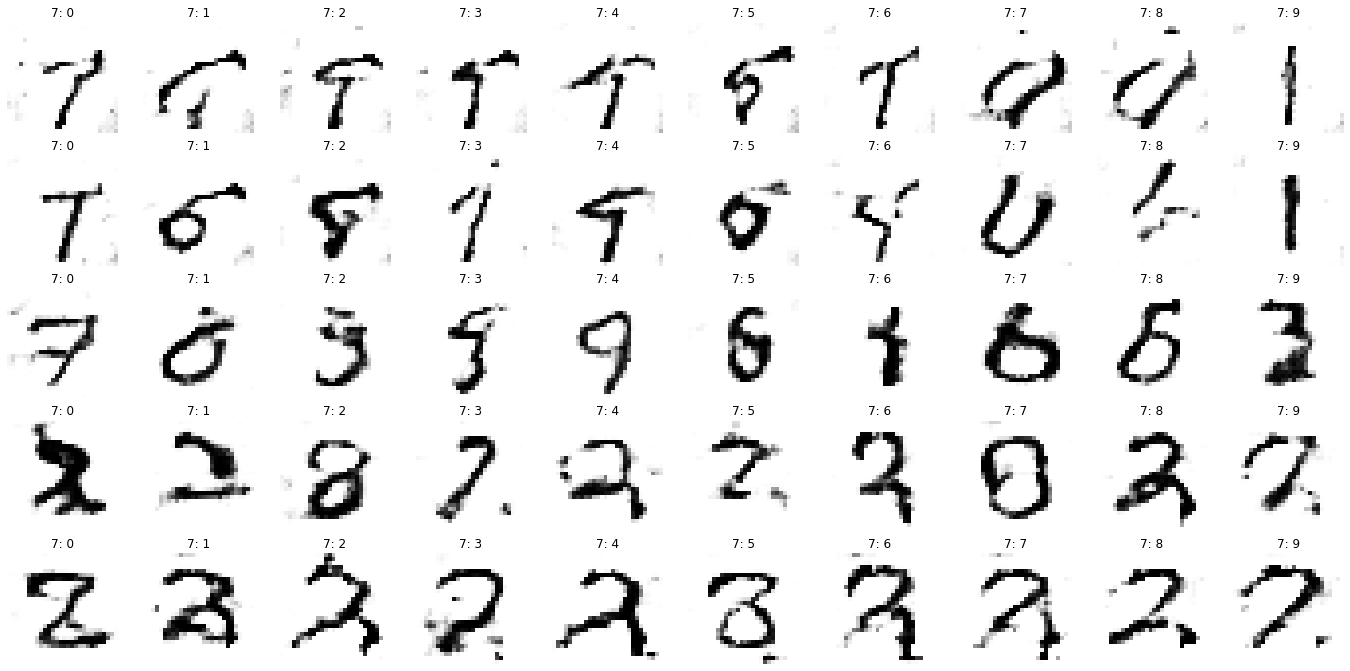

1: 100/100 


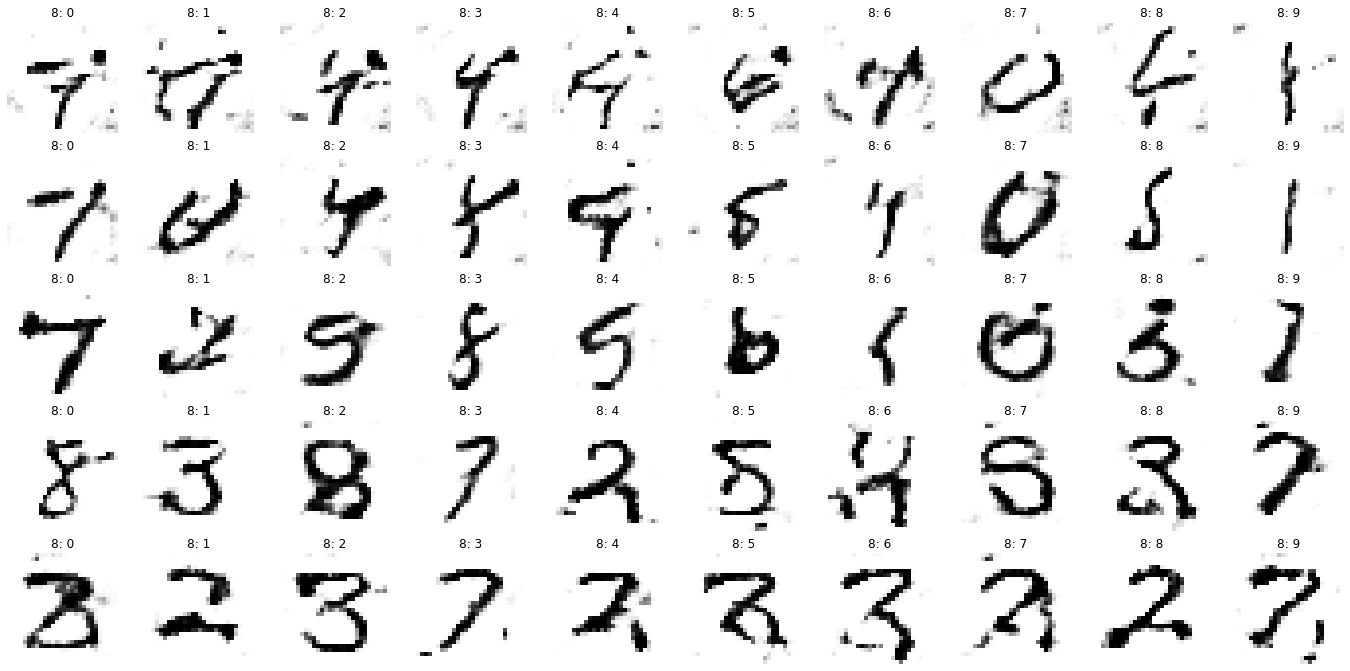

1: 100/100 


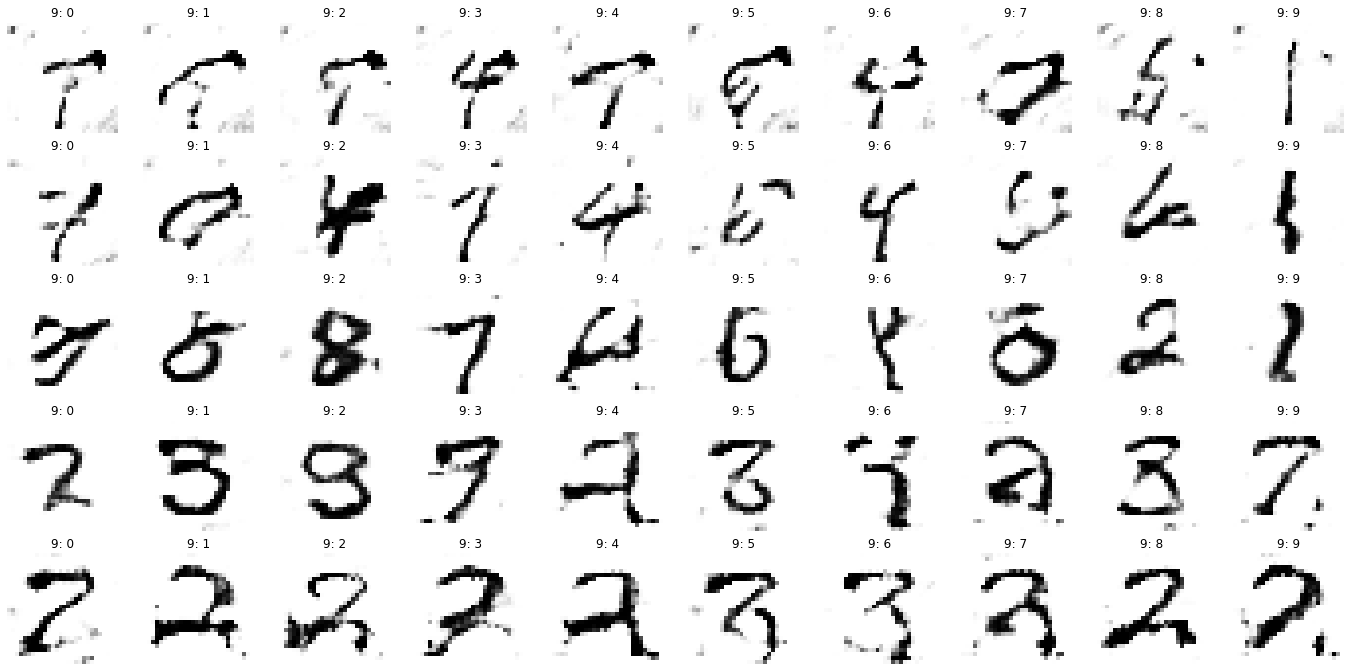

1: 100/100 


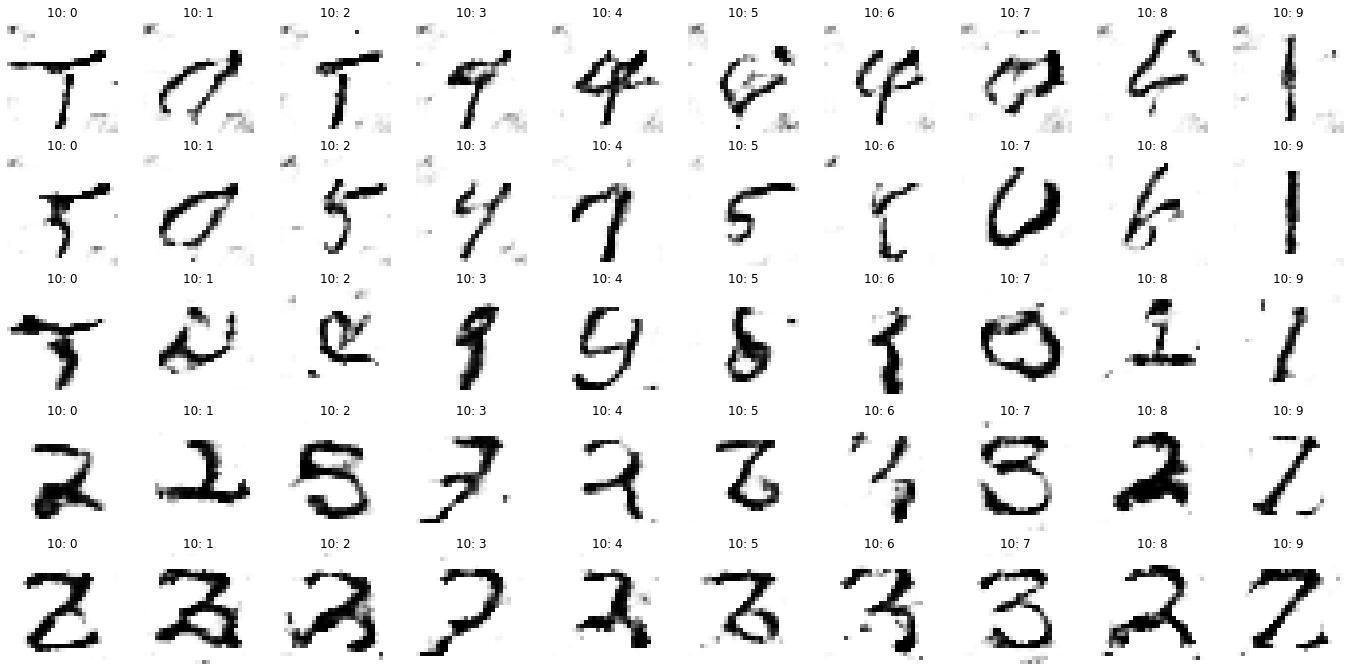

1: 100/100 


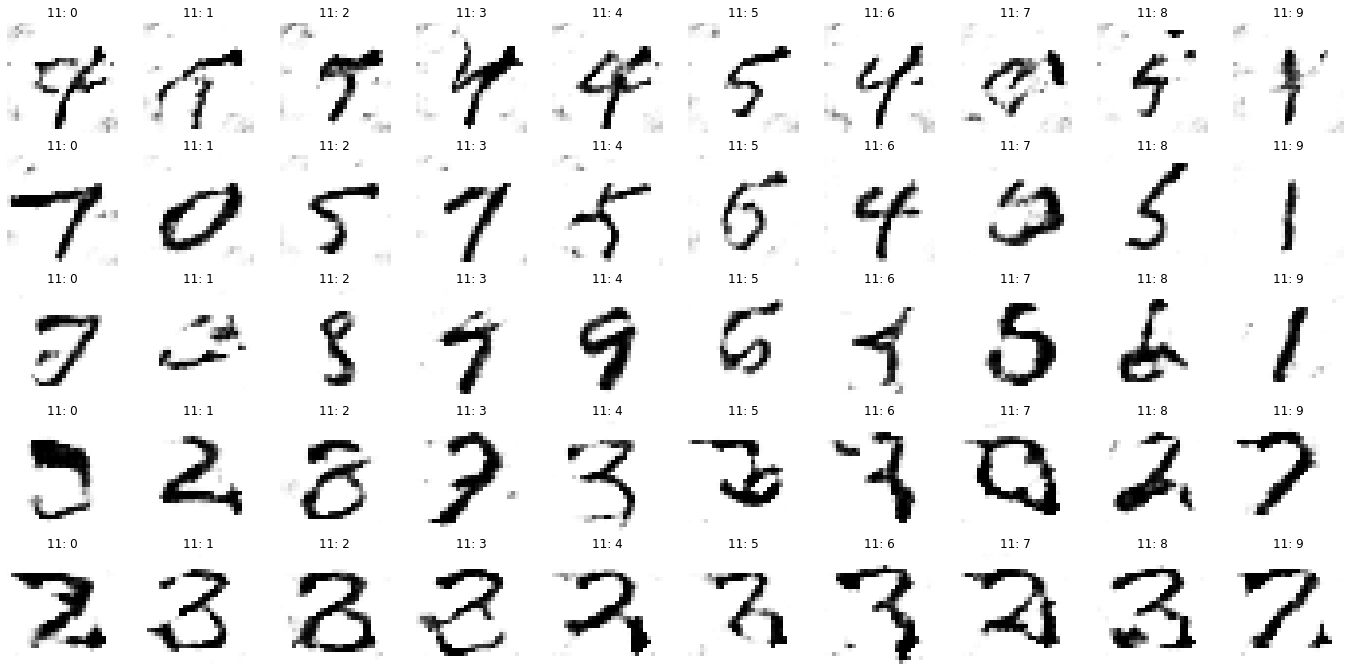

1: 100/100 


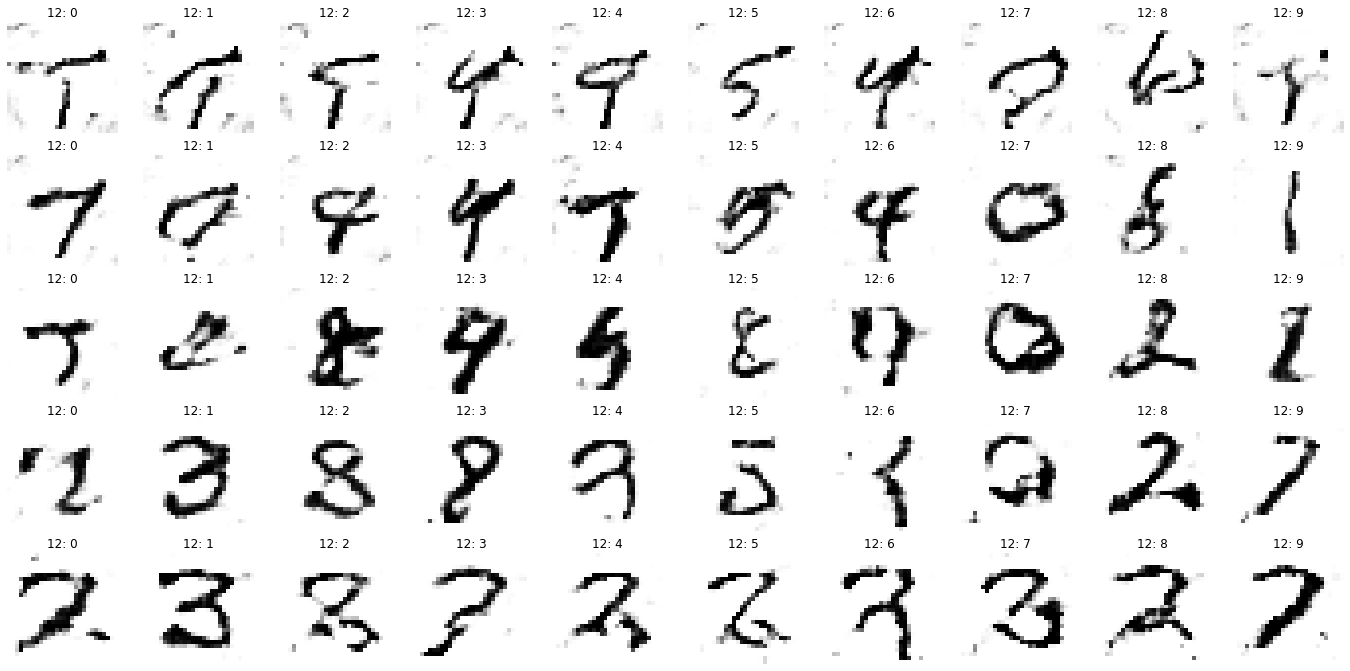

1: 100/100 


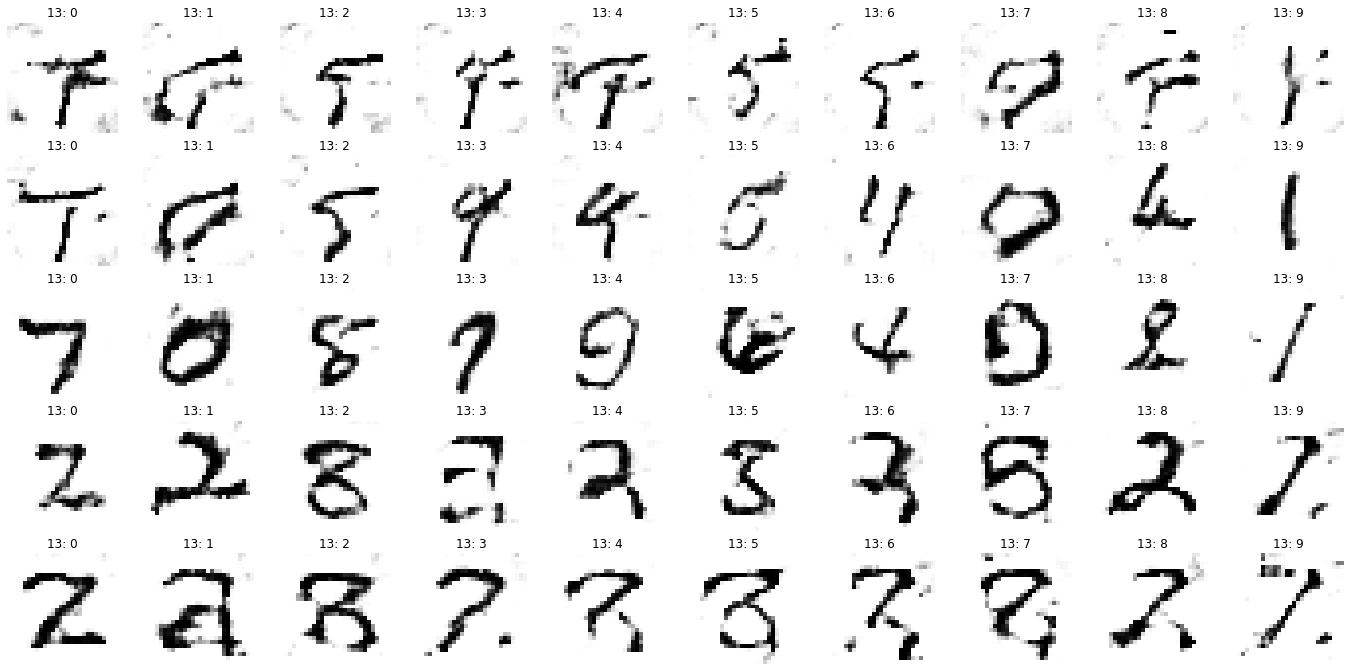

1: 100/100 


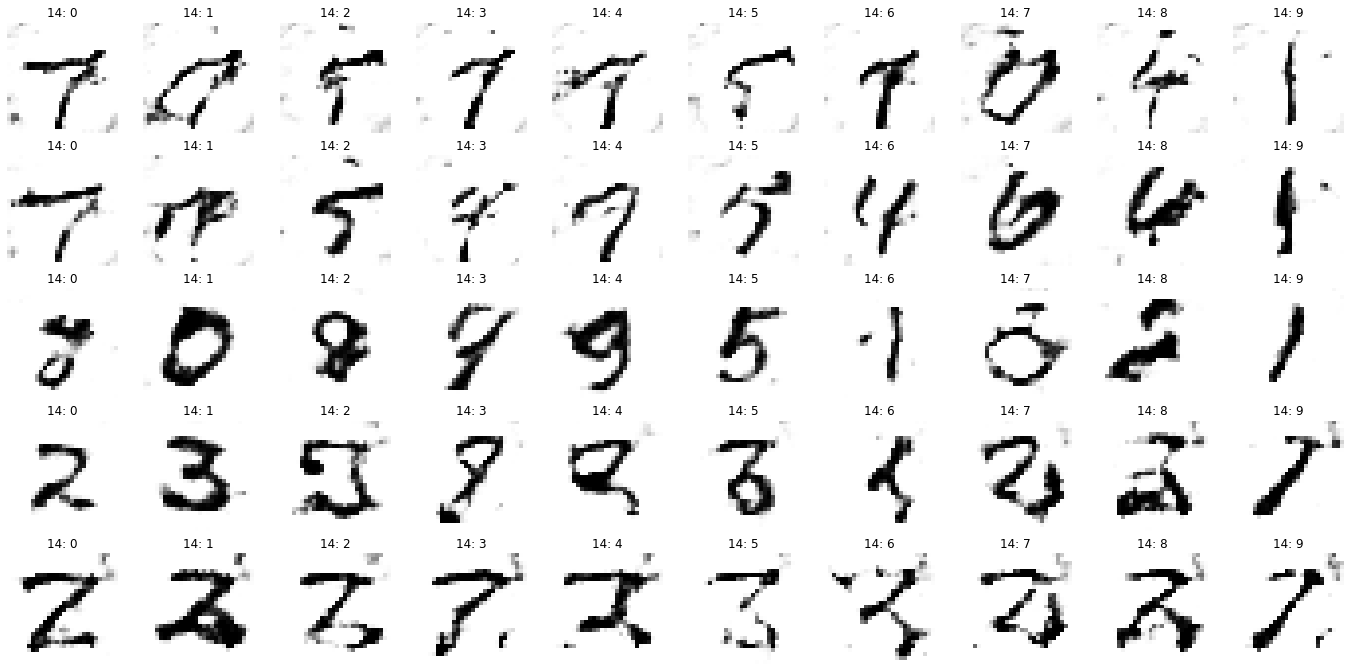

1: 100/100 


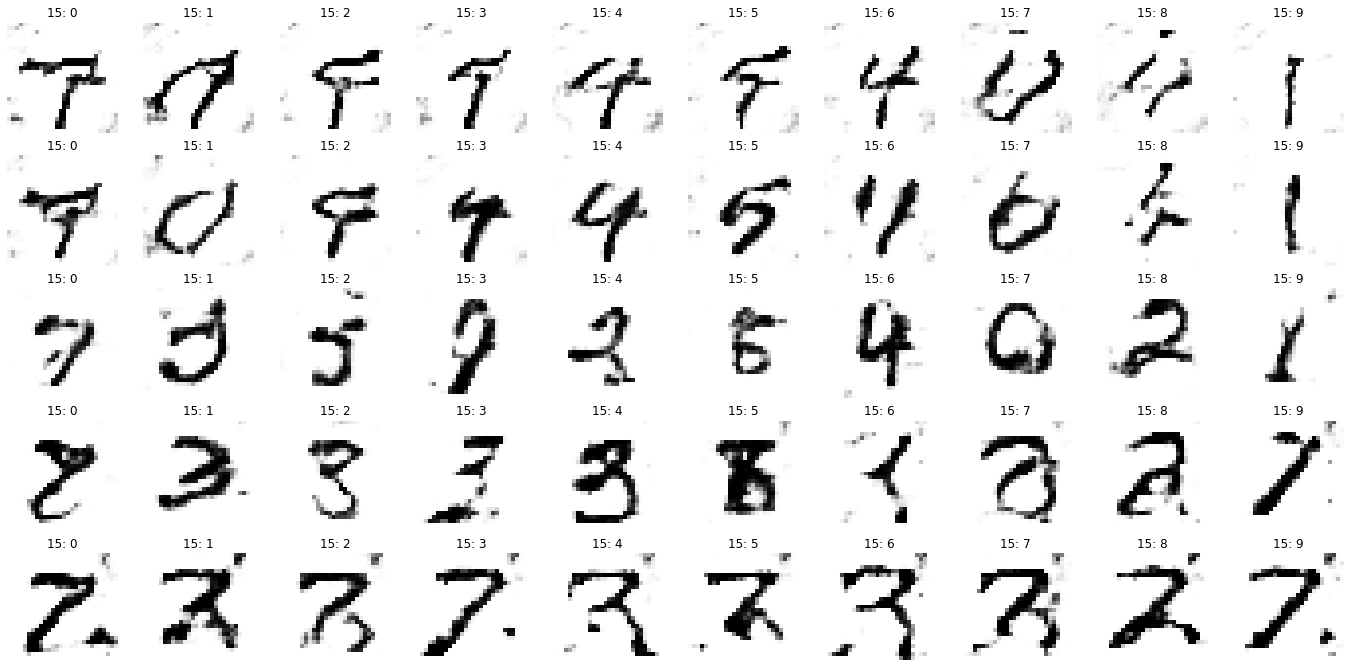

1: 100/100 


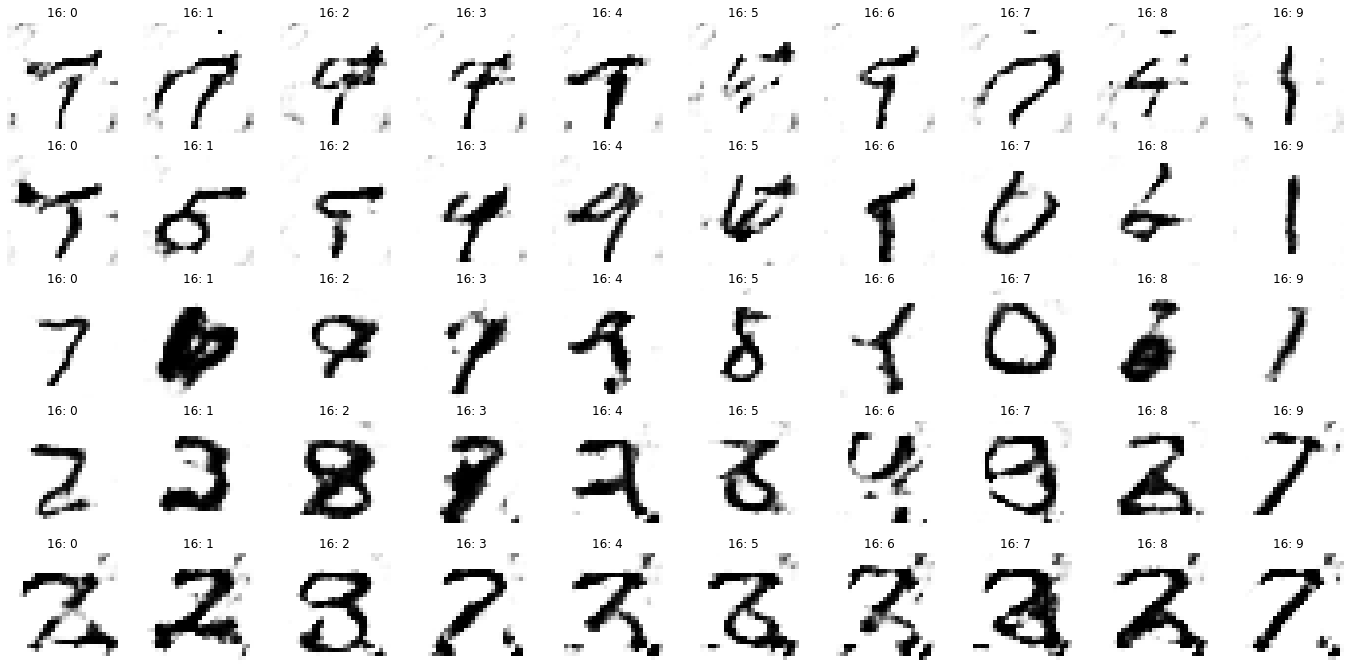

1: 100/100 


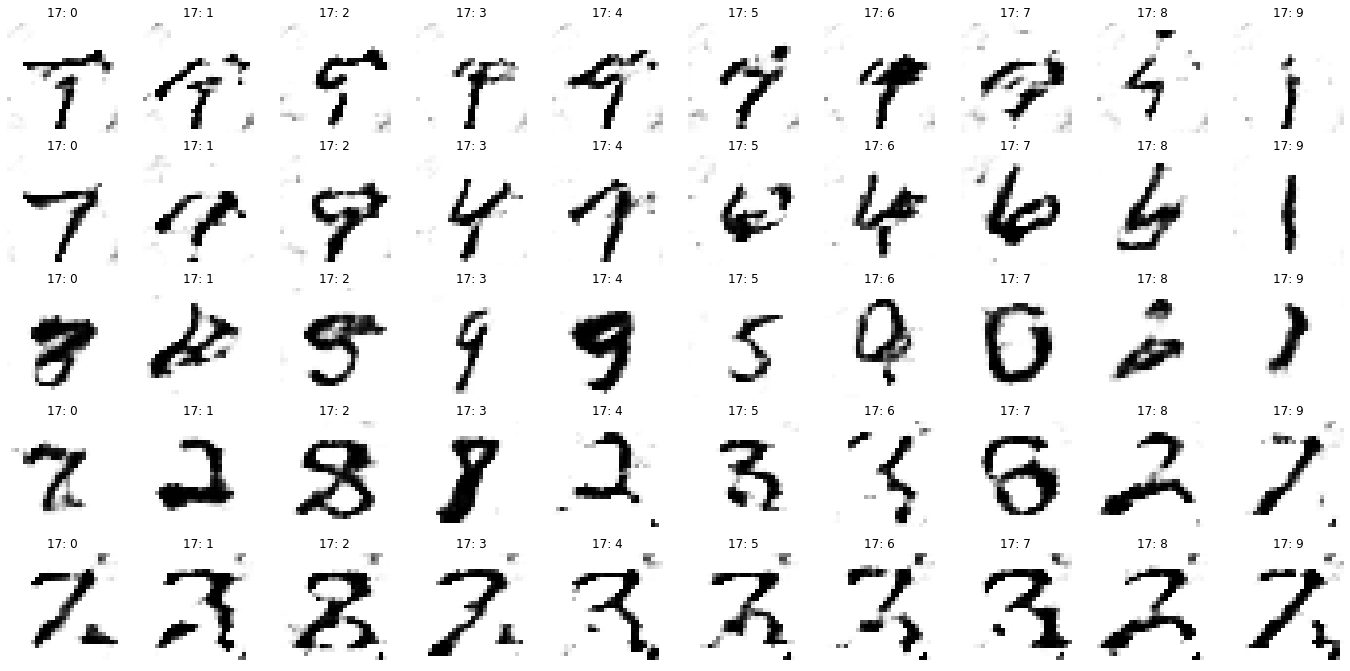

1: 100/100 


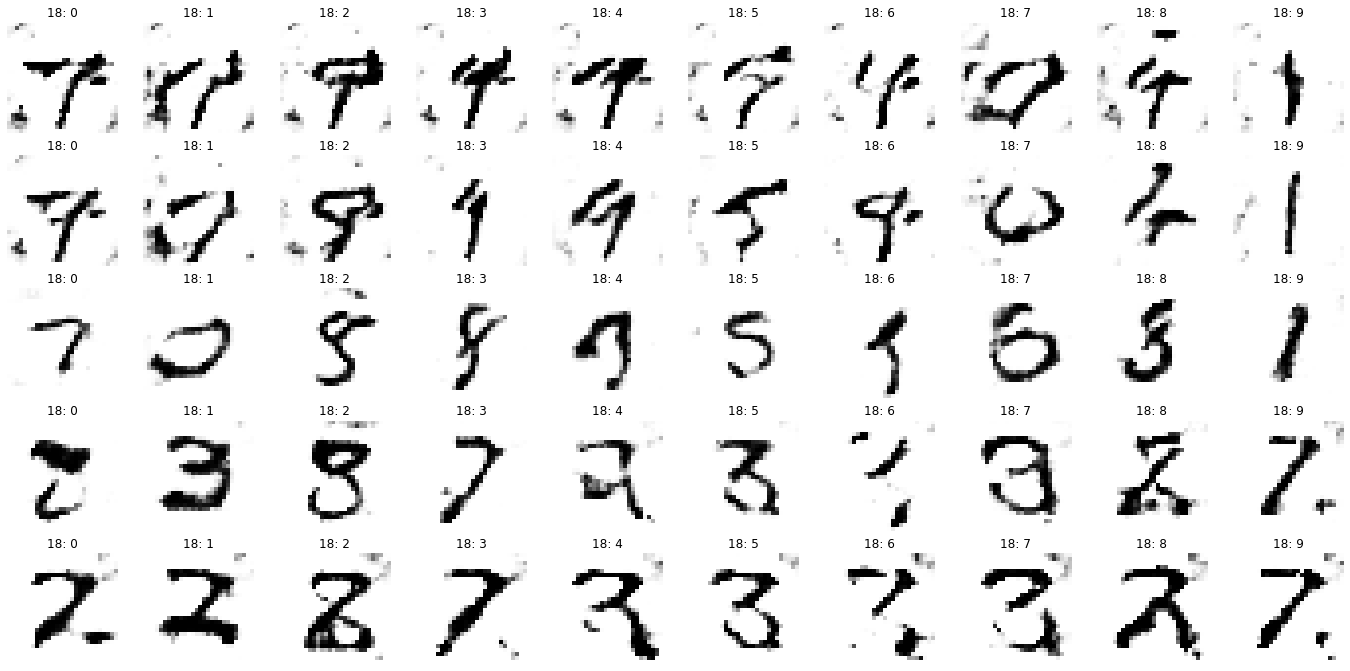

1: 100/100 


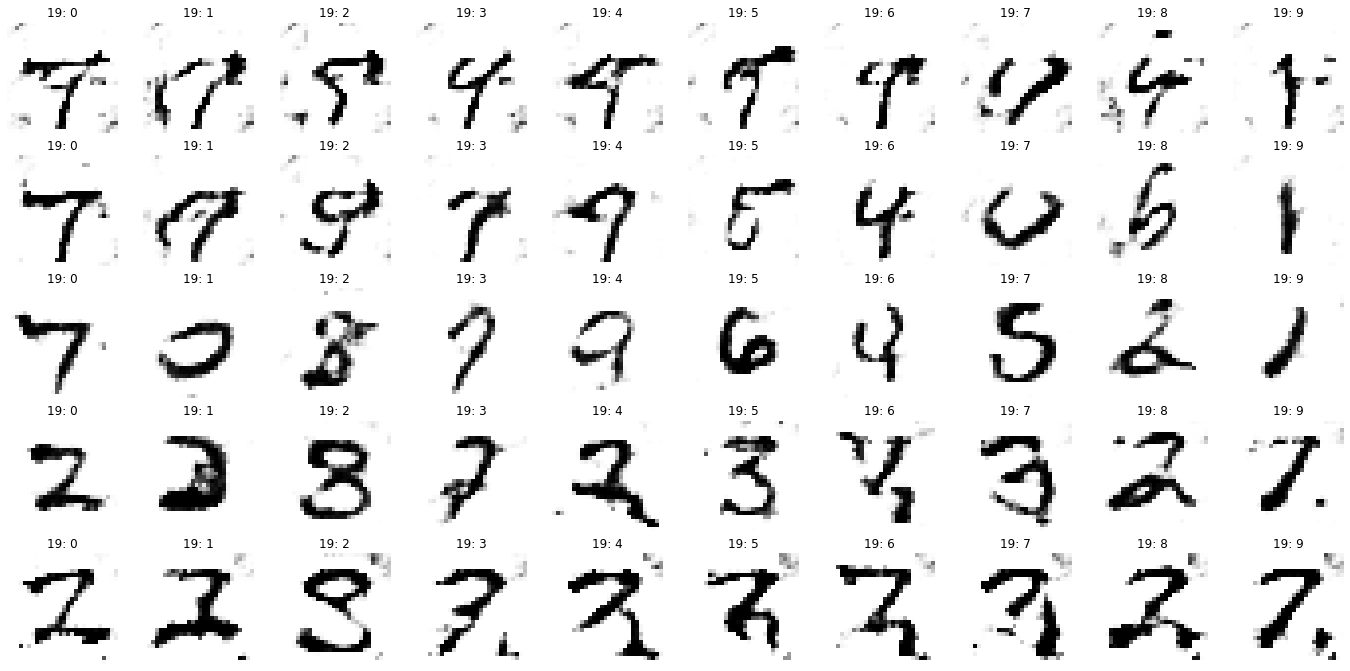

In [58]:
infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=2e-4,
    glr=2e-4,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
mnistTrainPlot(
    infogan1,
    epochs = 20,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)

In [59]:
gen = load_model((f'{name} 10.h5'))

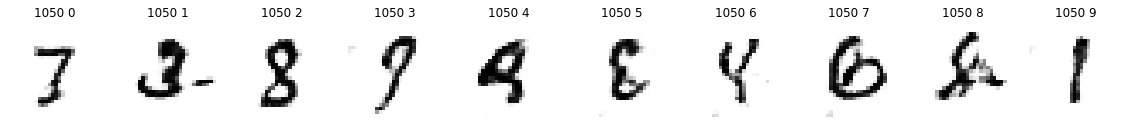

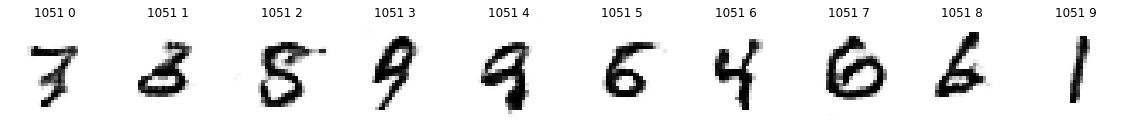

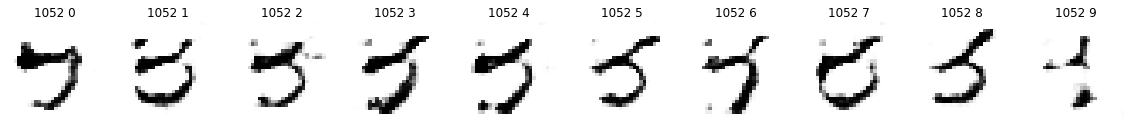

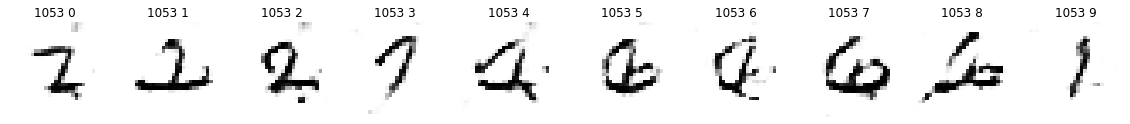

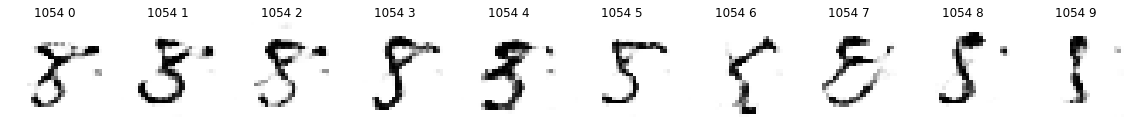

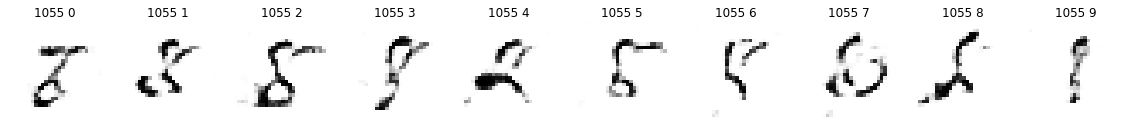

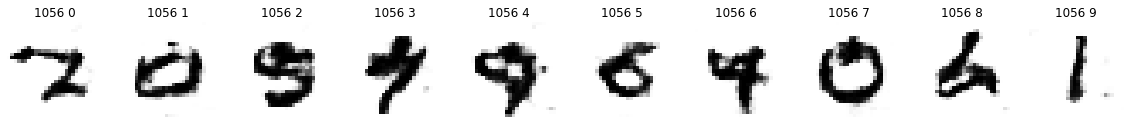

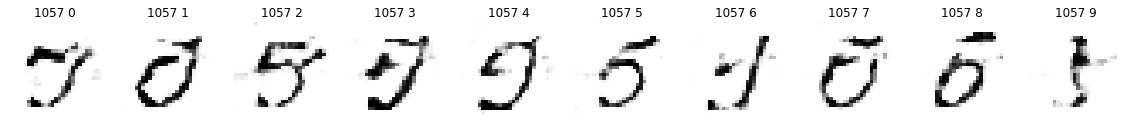

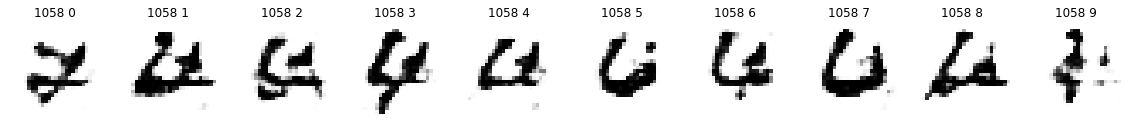

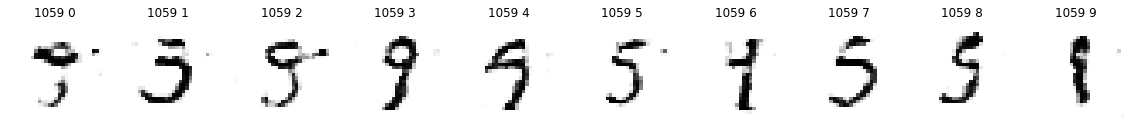

In [61]:
for i in range(10):
    seed = 1050 + i
    plotc1(gen, seed=seed, titleStart = f'{seed} ')

In [62]:
print(name)

2021-04-14 23-16-50


In [63]:
print(f'{name} 10.h5')

2021-04-14 23-16-50 10.h5


2021-04-14 23-26-27
2021-04-14 23-26-27 10.h5
1: 100/100 


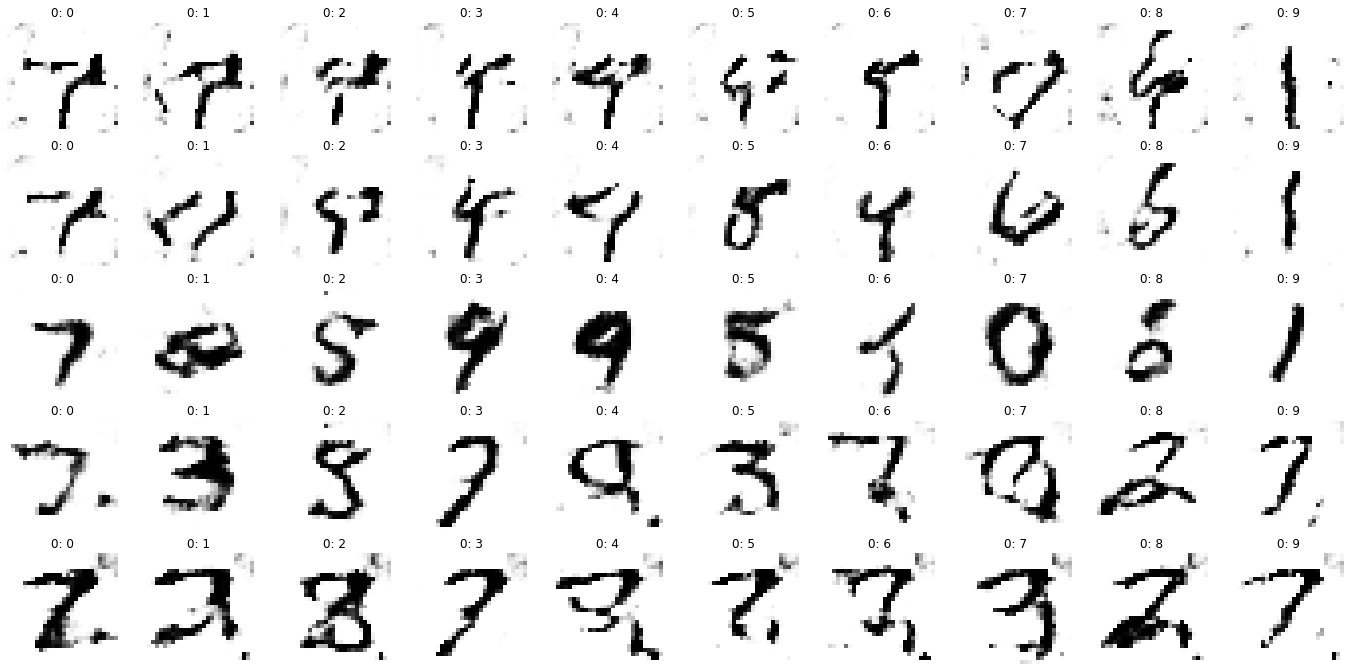

1: 100/100 


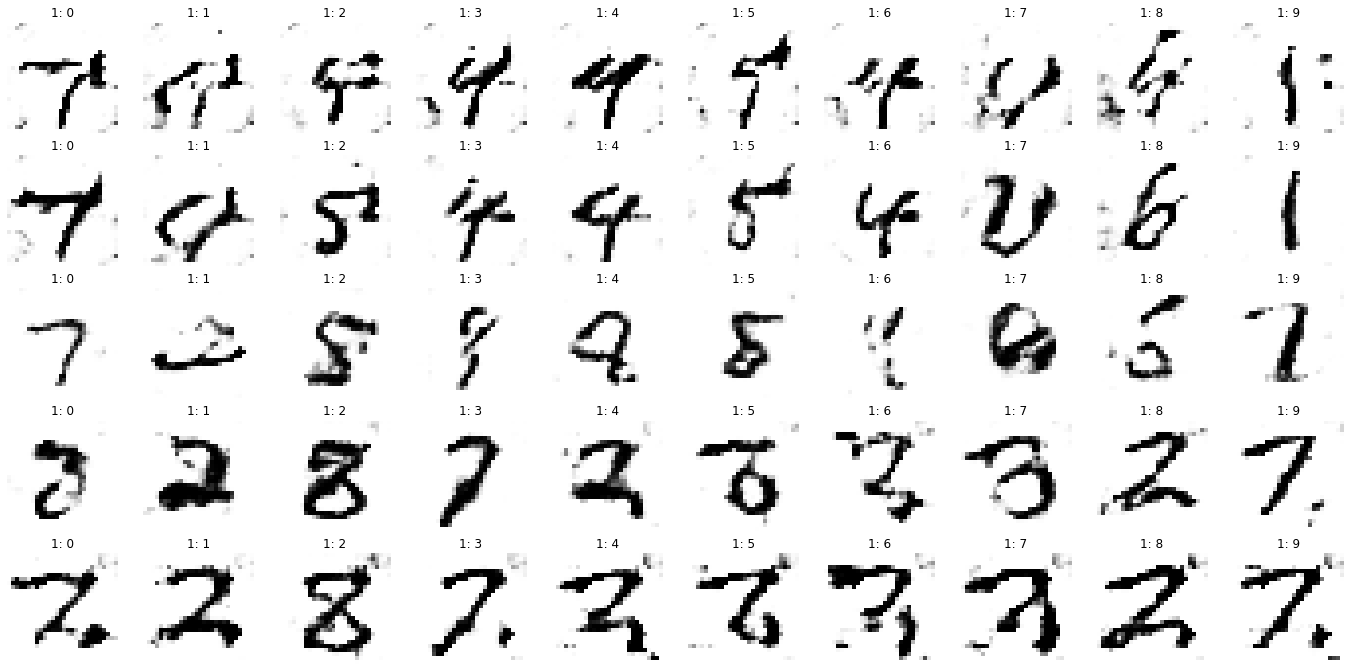

1: 100/100 


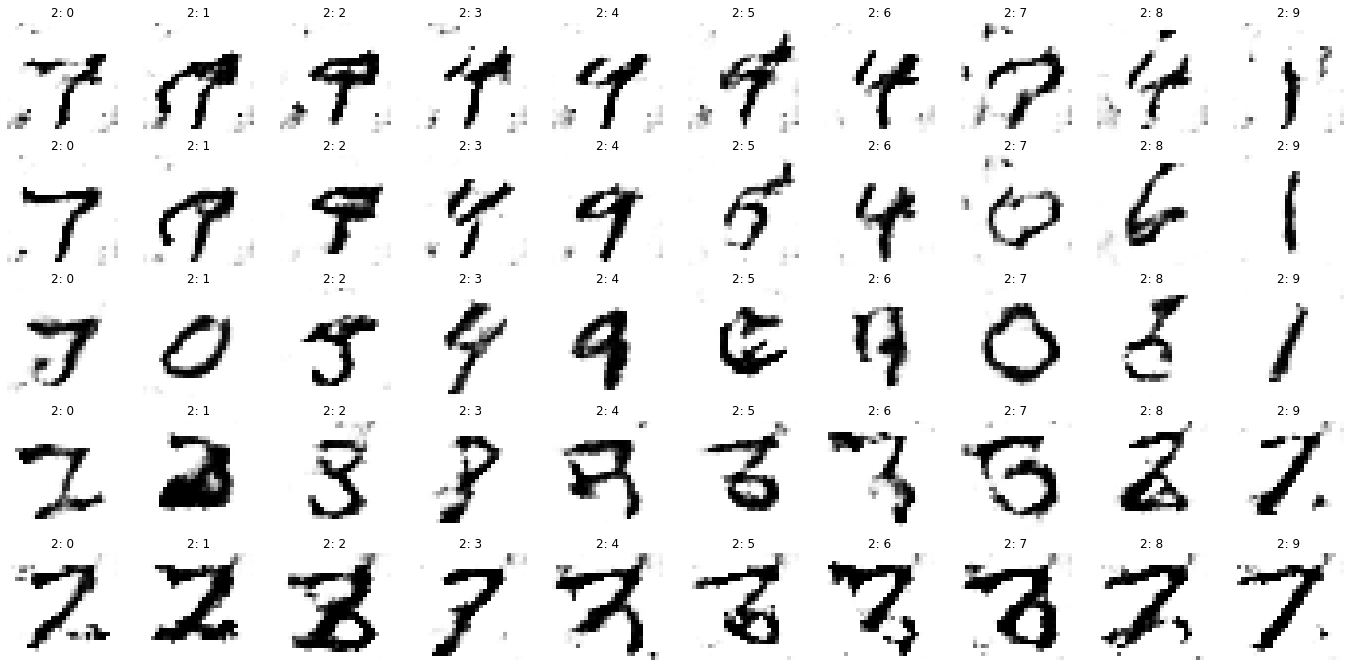

1: 100/100 


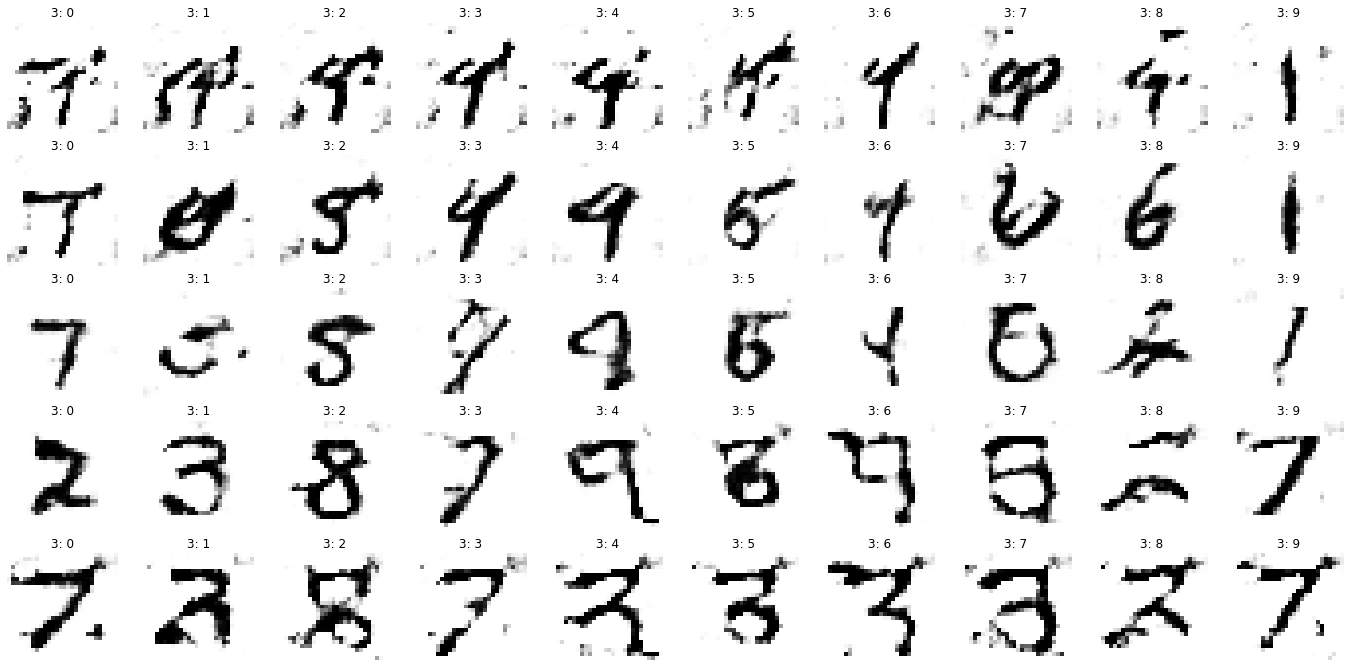

1: 100/100 


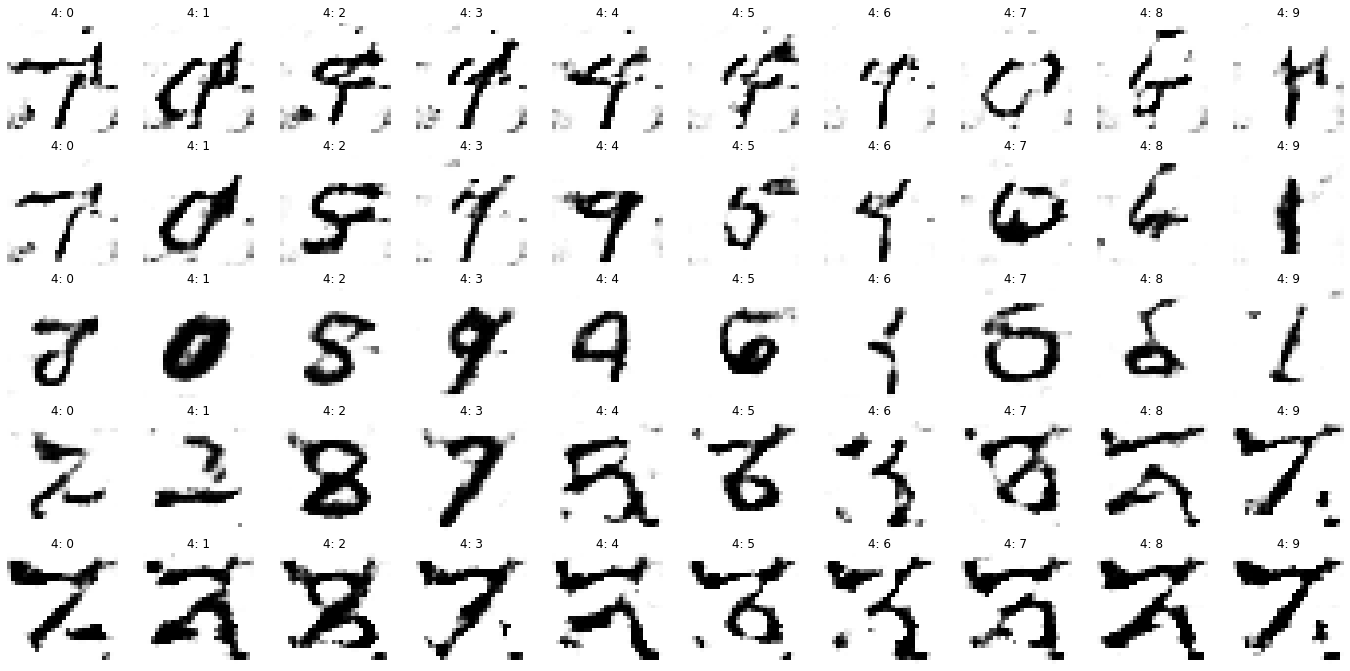

1: 100/100 


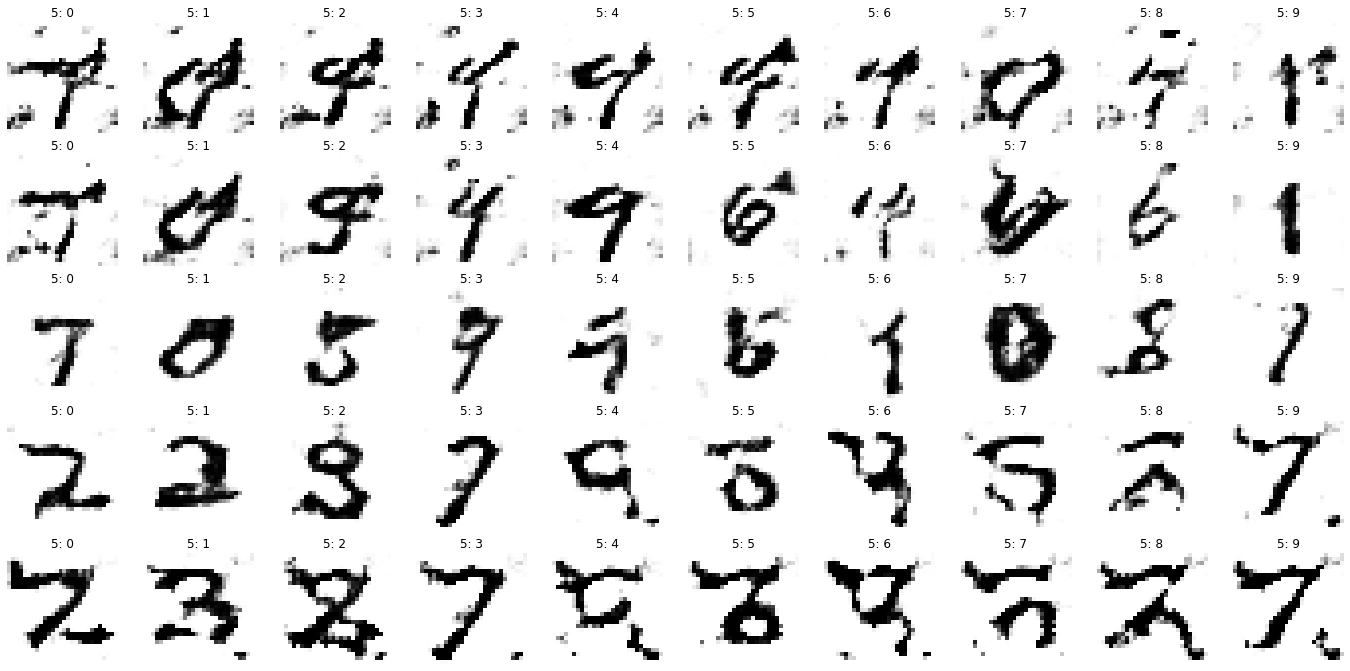

1: 100/100 


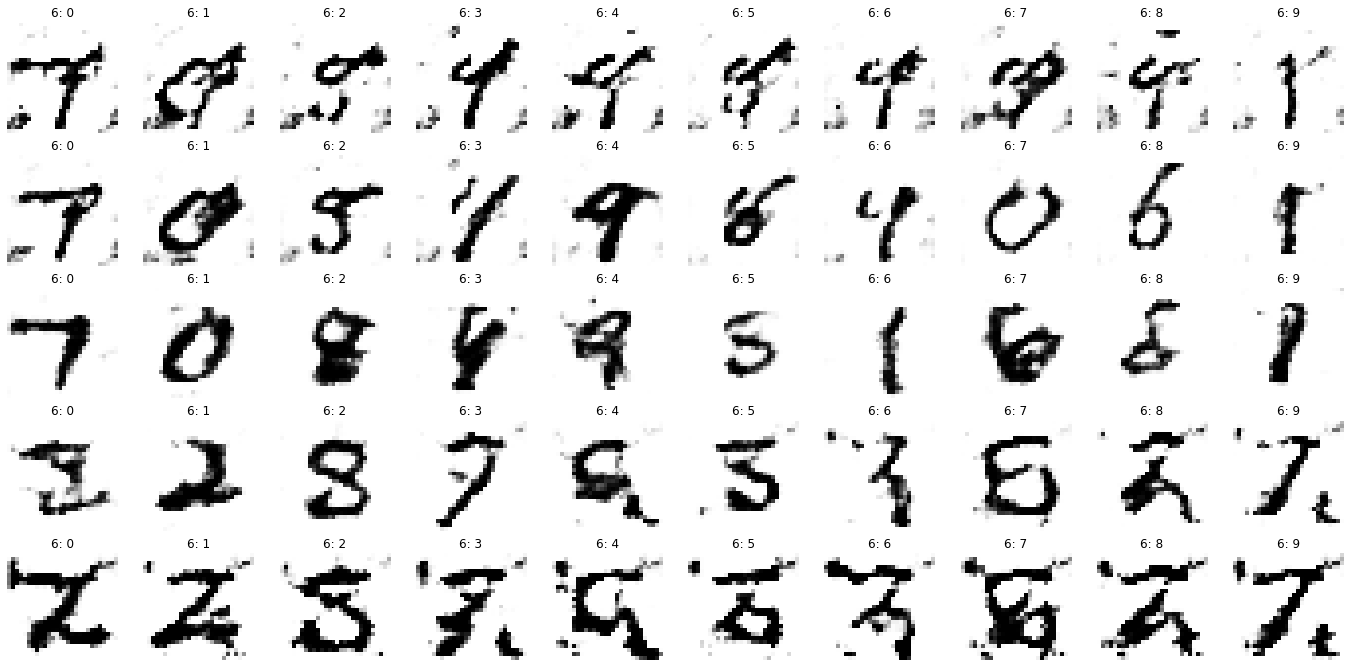

1: 100/100 


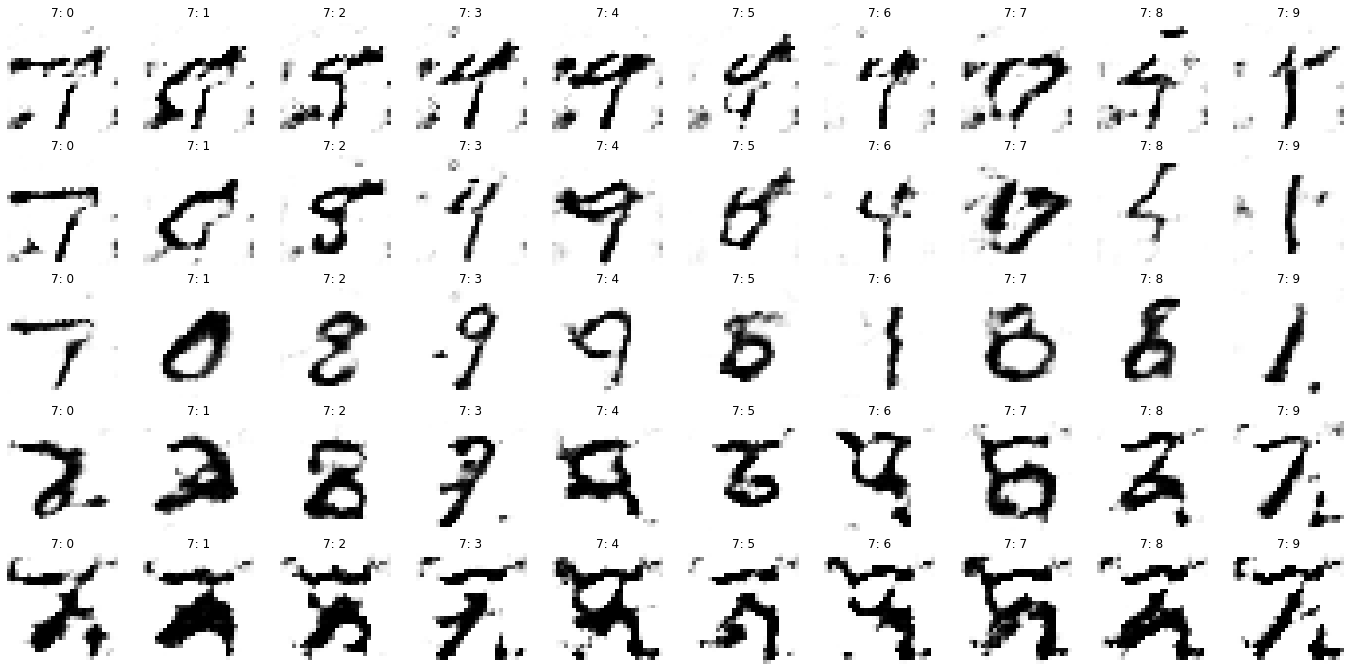

1: 100/100 


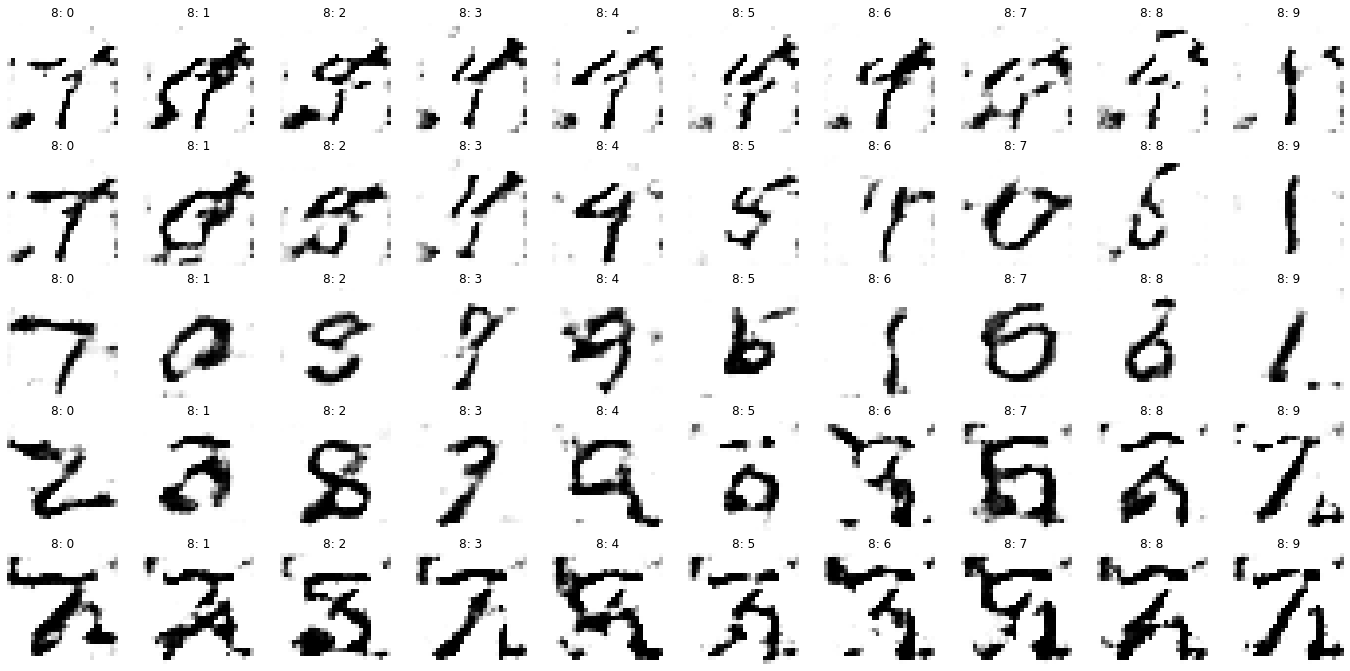

1: 100/100 


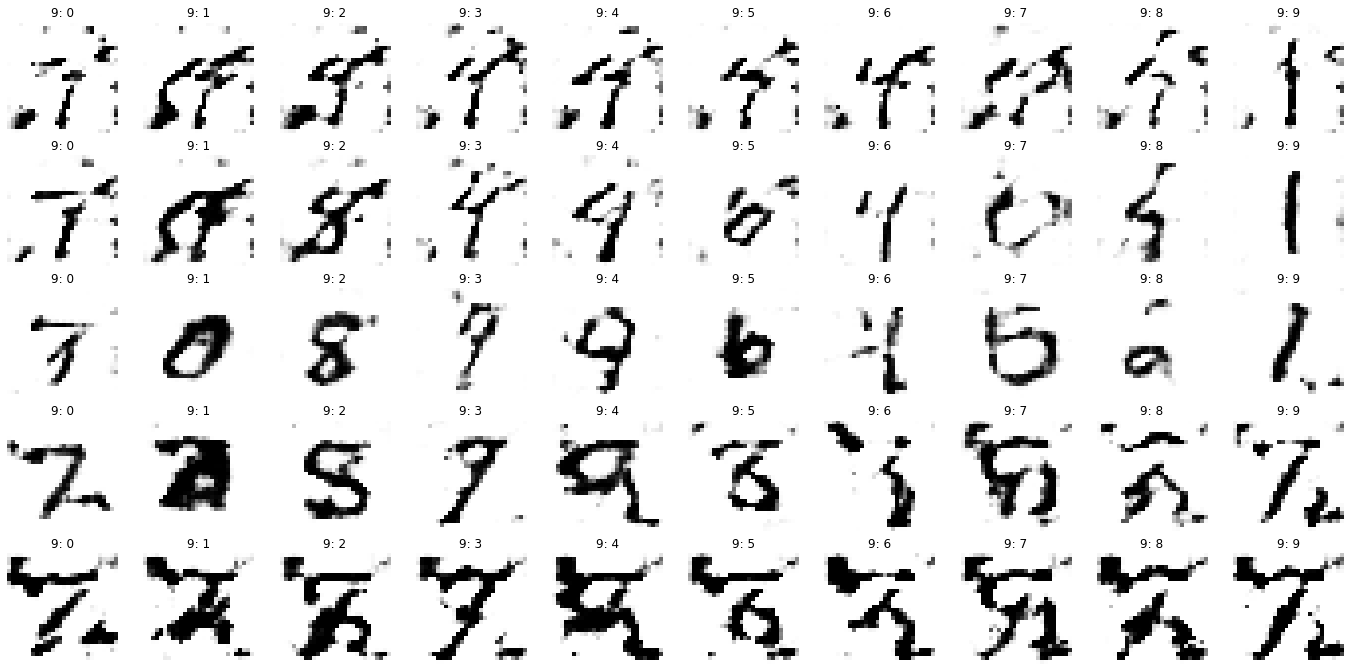

1: 100/100 


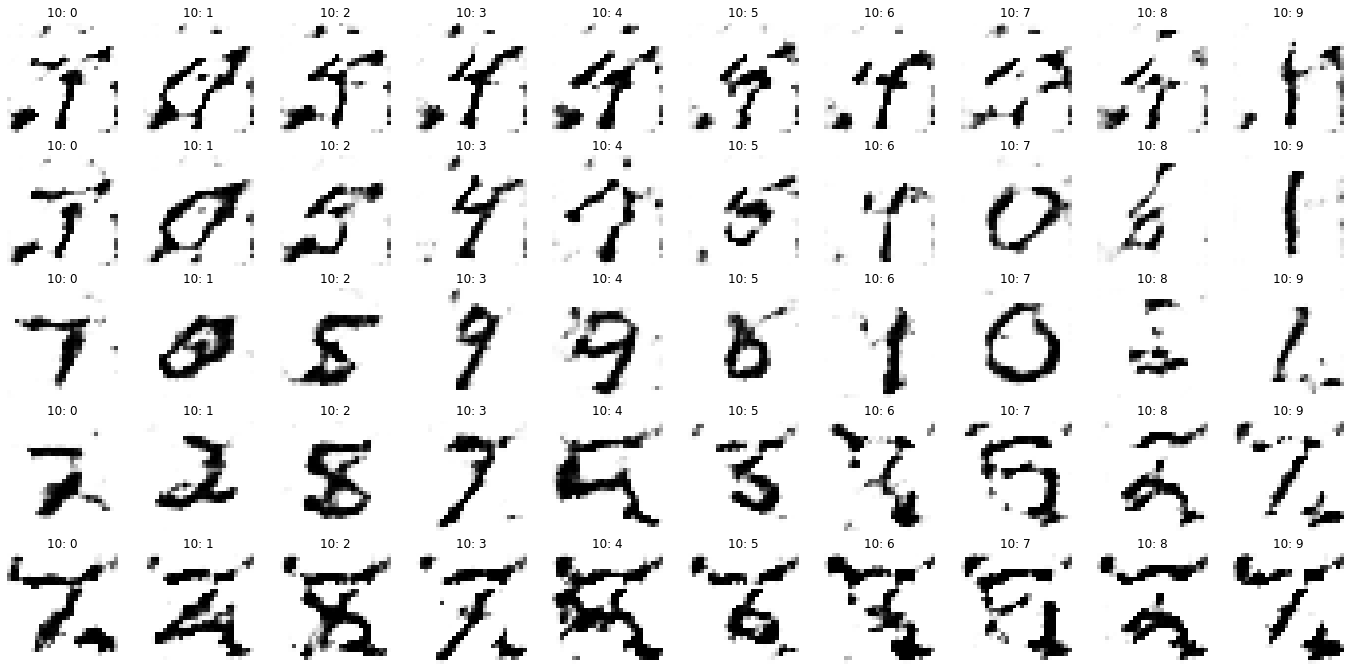

1: 100/100 


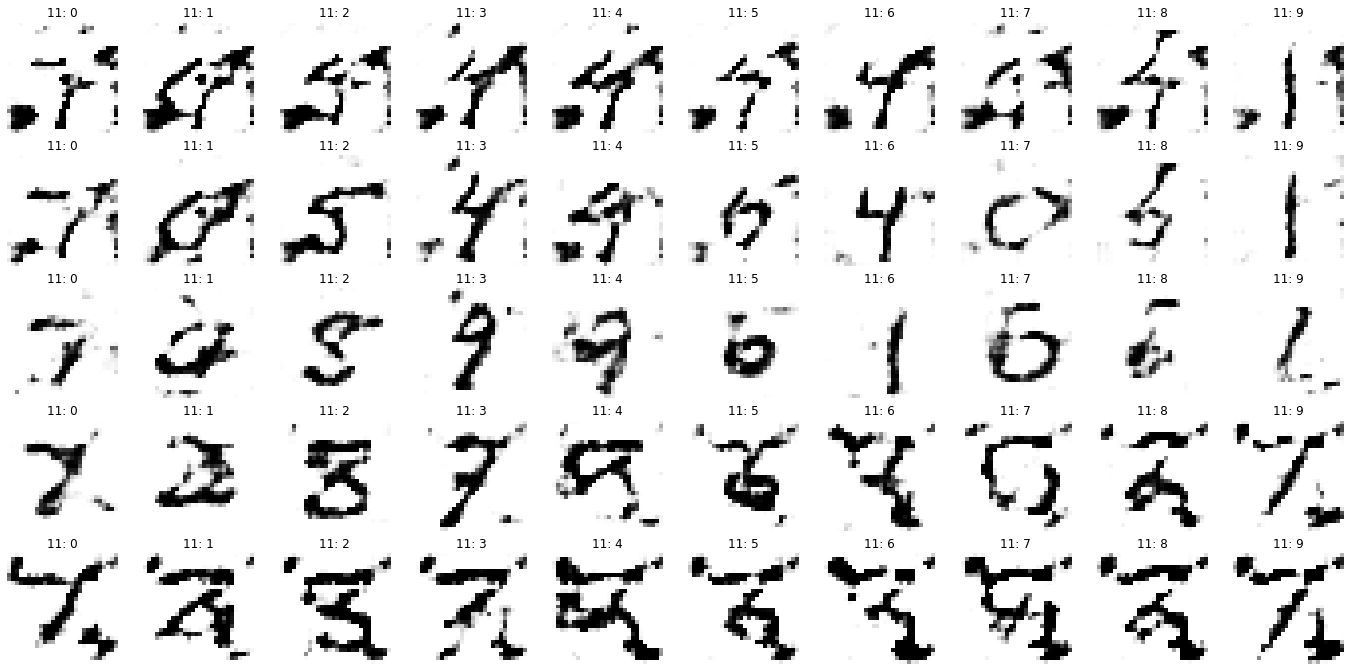

1: 100/100 


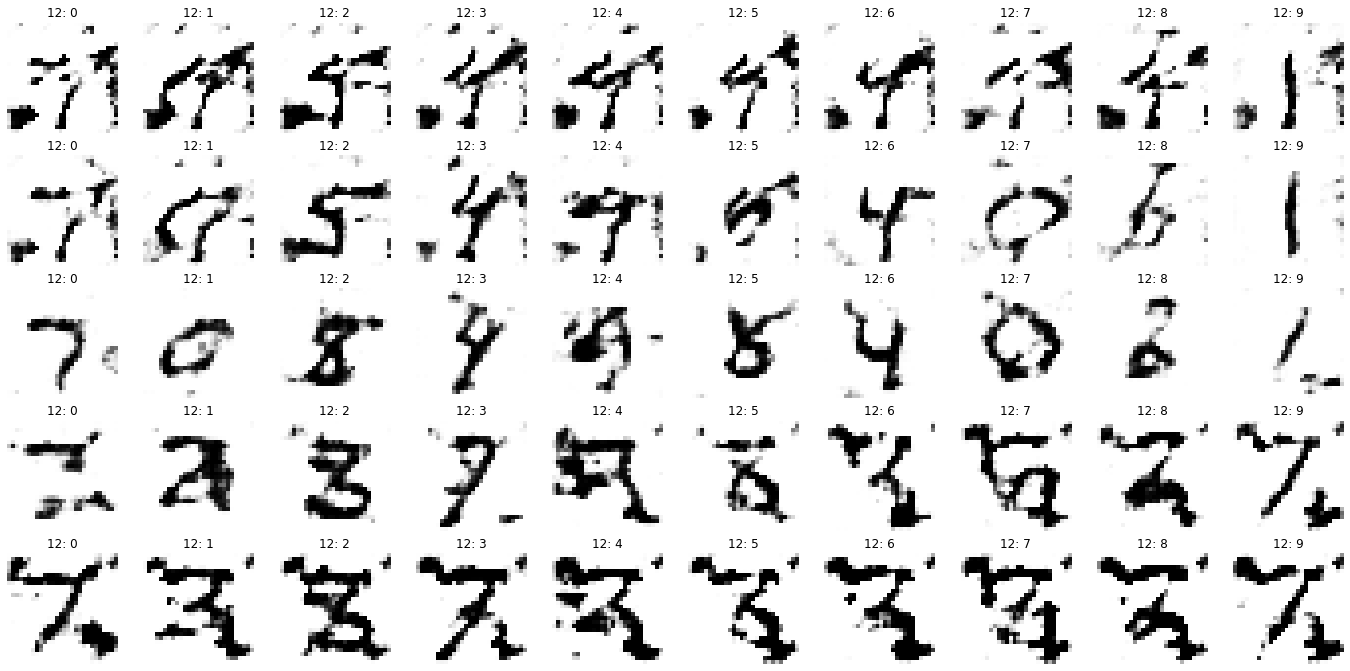

1: 100/100 


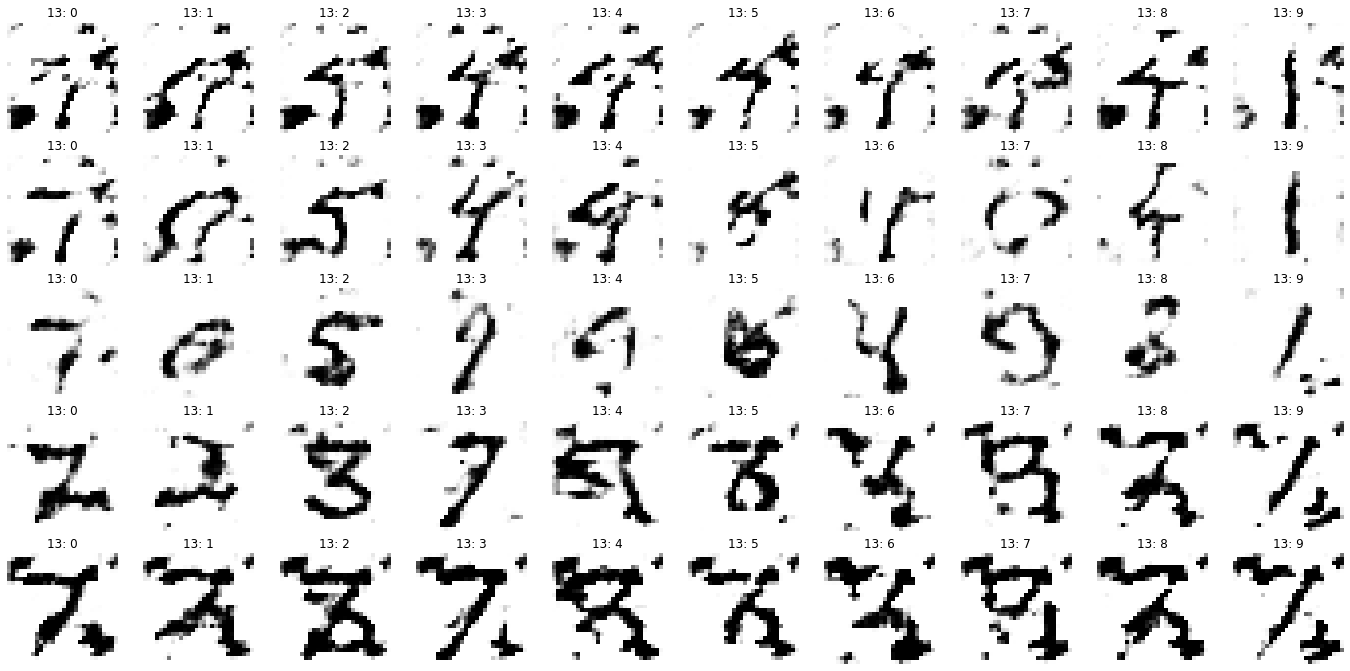

1: 100/100 


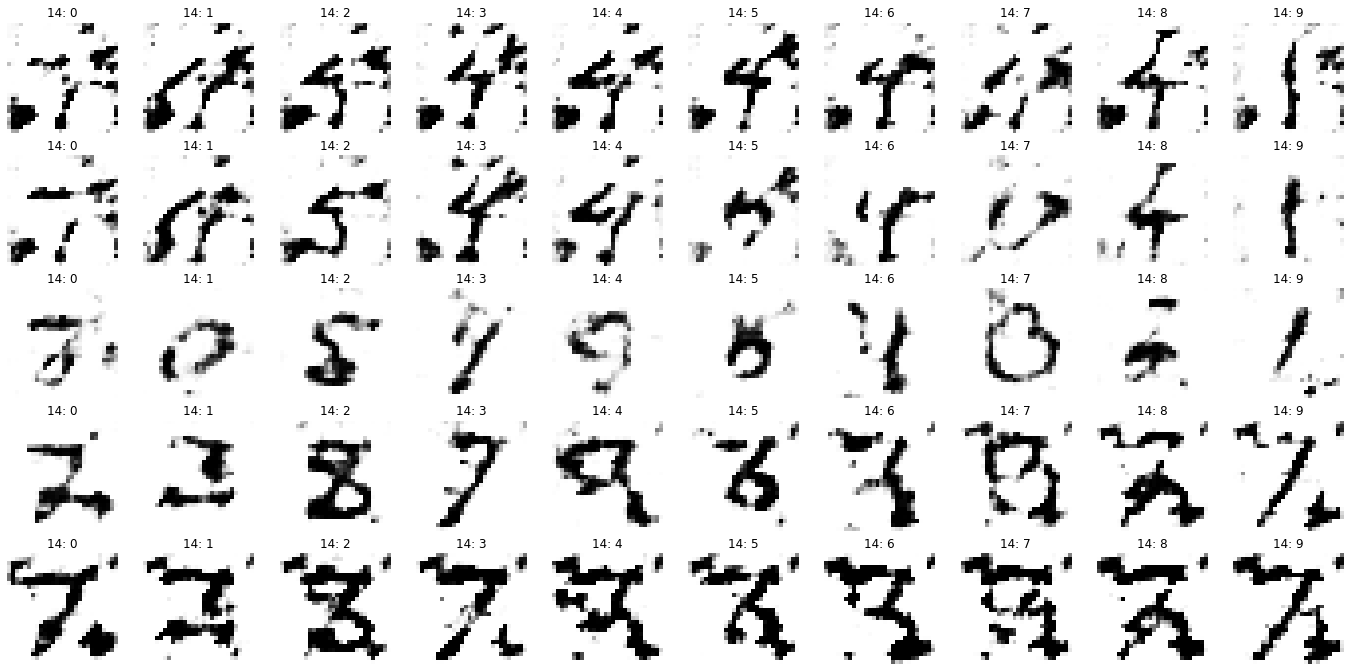

1: 100/100 


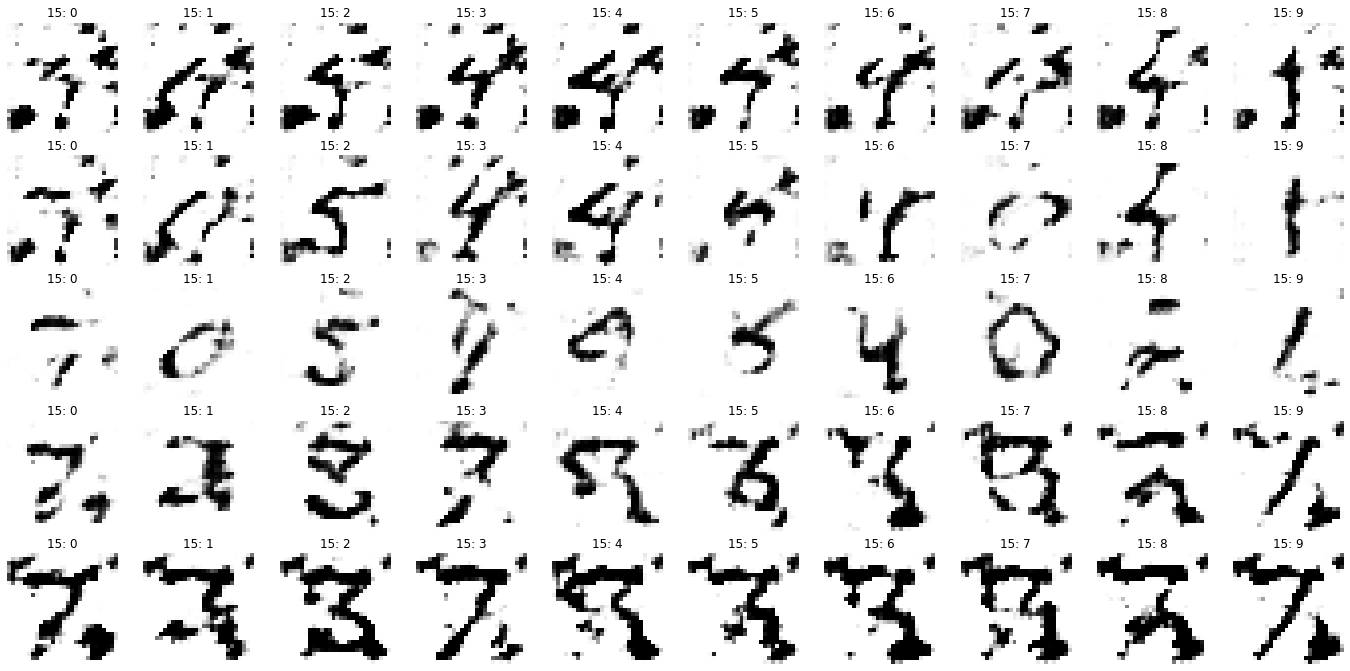

1: 100/100 


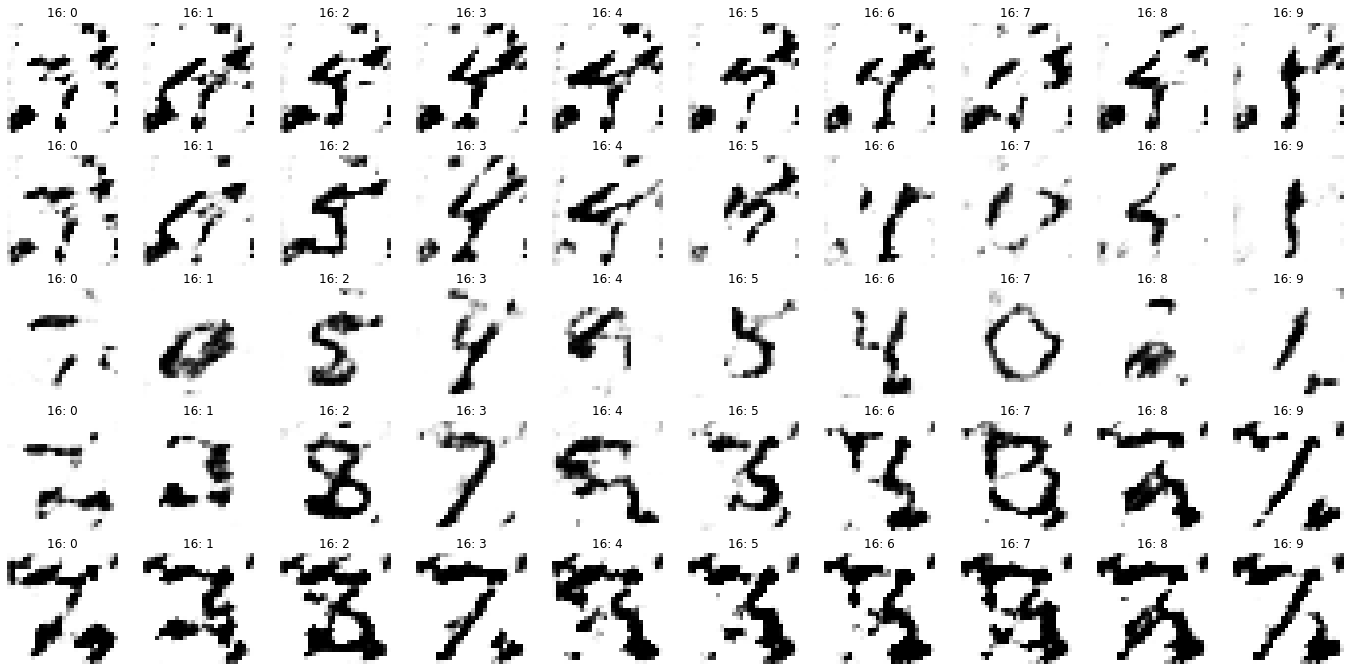

1: 100/100 


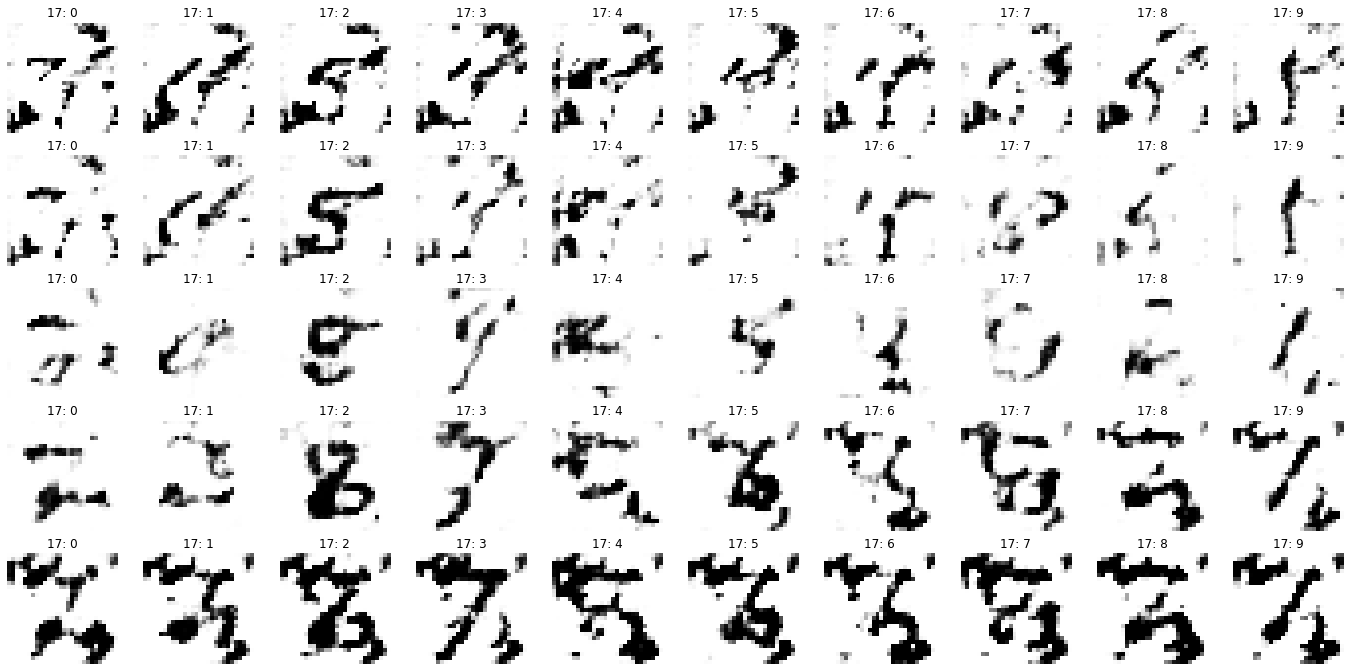

1: 100/100 


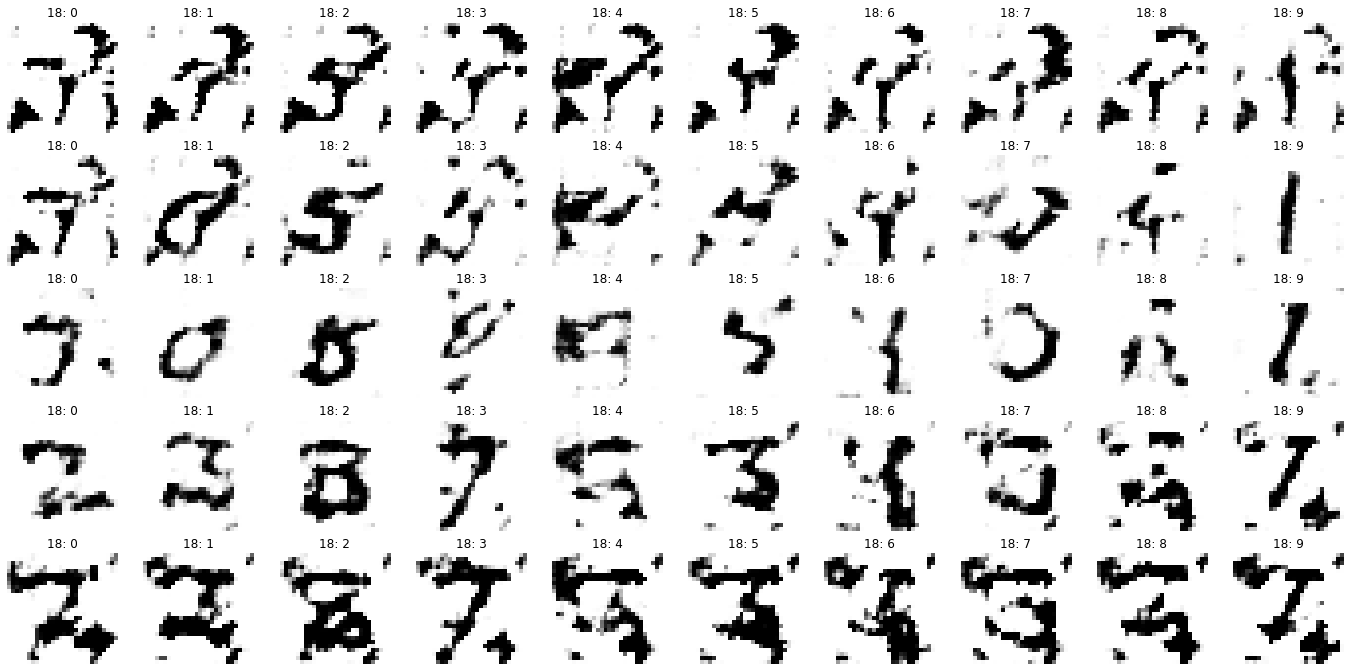

1: 100/100 


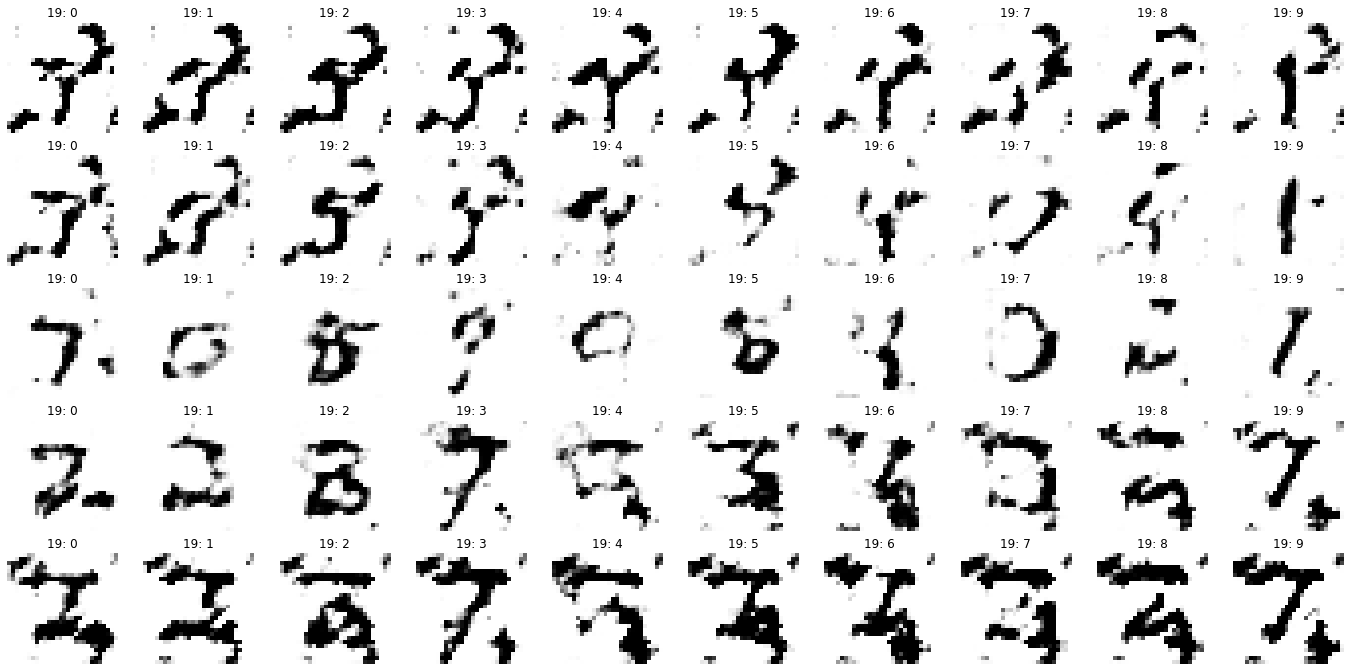

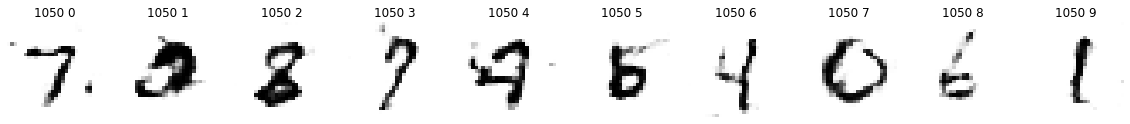

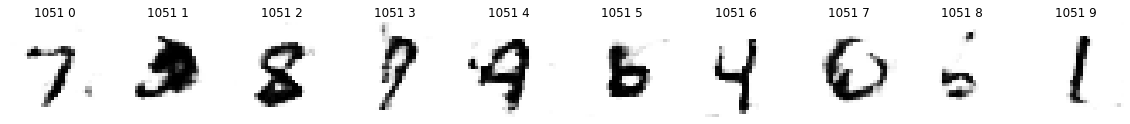

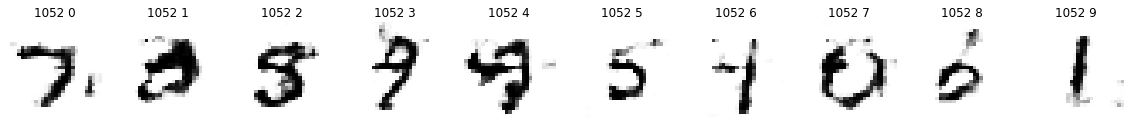

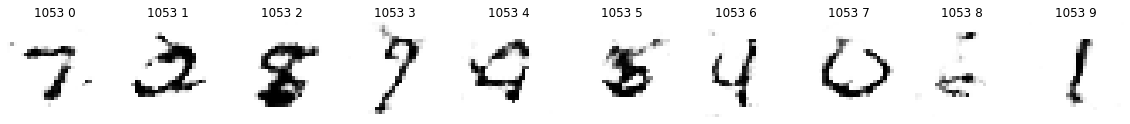

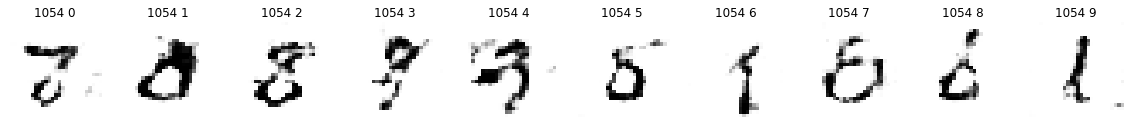

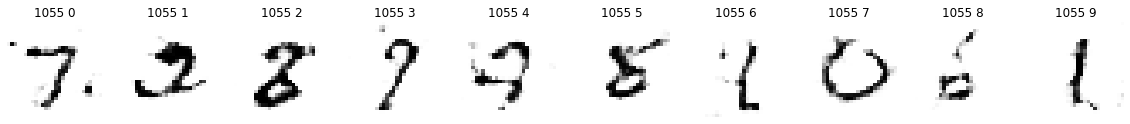

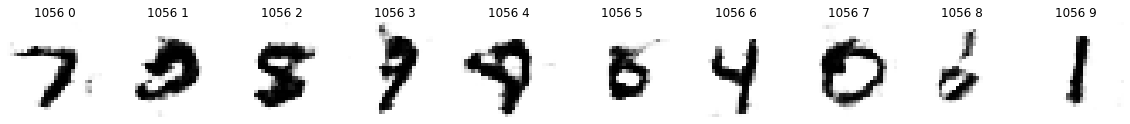

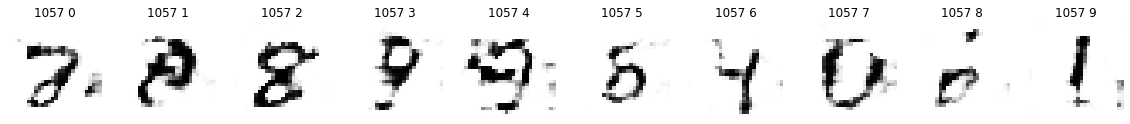

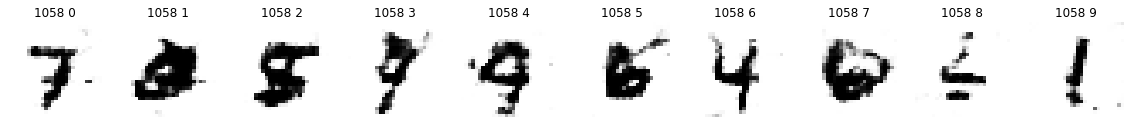

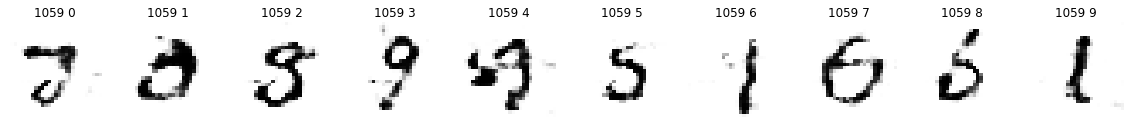

In [64]:
infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=2e-4,
    glr=1e-3,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
print(name)
print(f'{name} 10.h5')
mnistTrainPlot(
    infogan1,
    epochs = 20,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)
gen = load_model((f'{name} 10.h5'))
for i in range(10):
    seed = 1050 + i
    plotc1(gen, seed=seed, titleStart = f'{seed} ')

In [ ]:
infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=1e-4,
    glr=2e-4,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
print(name)
print(f'{name} 10.h5')
mnistTrainPlot(
    infogan1,
    epochs = 20,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)

2021-04-14 23-36-04
2021-04-14 23-36-04 10.h5
1: 100/100 


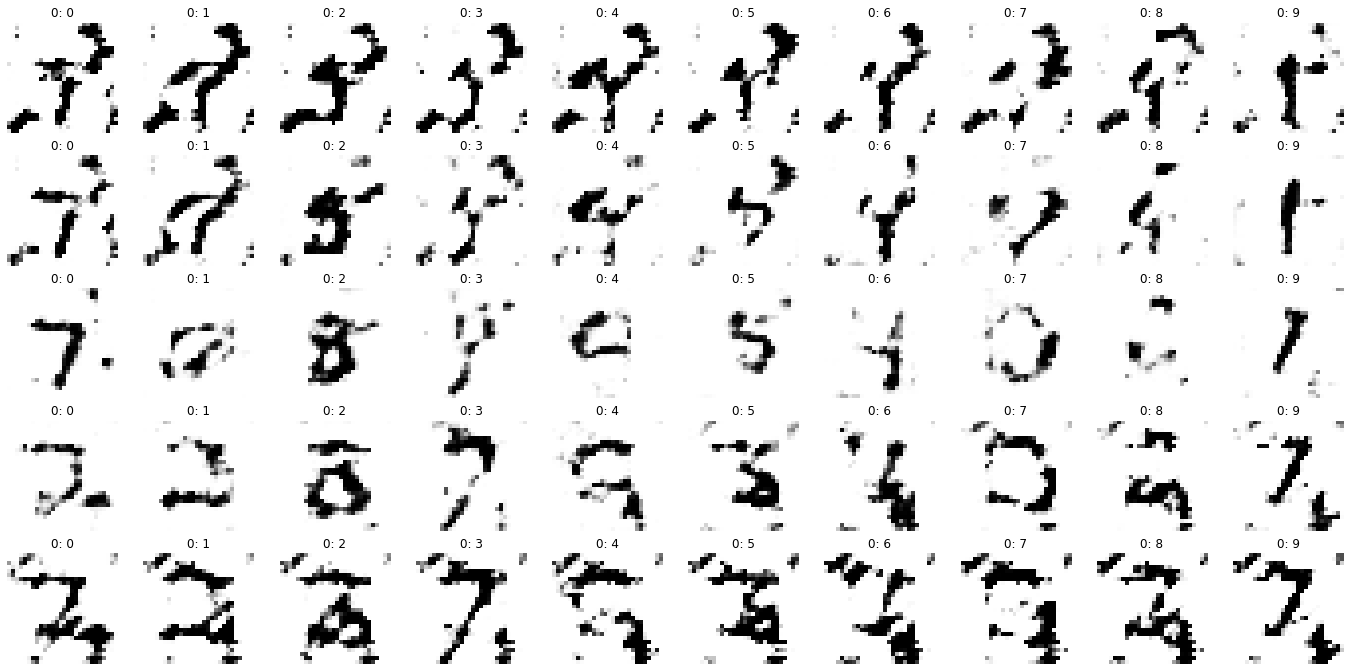

1: 100/100 


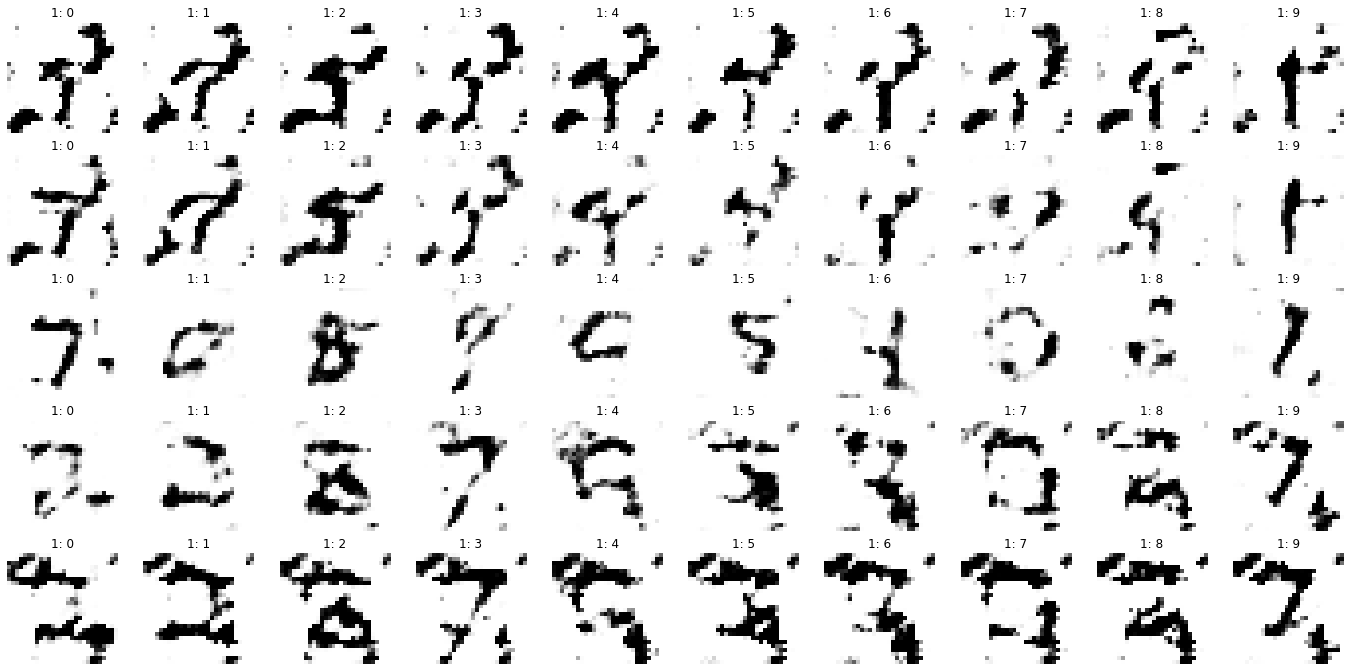

1: 100/100 


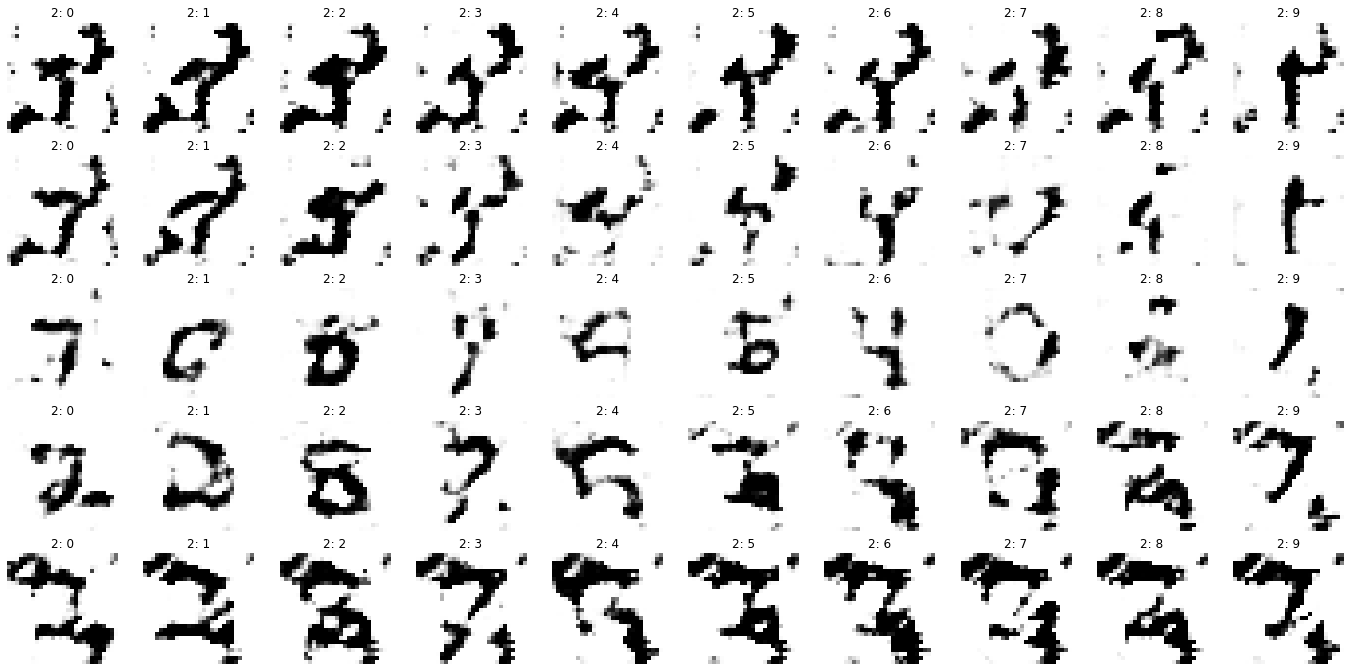

1: 100/100 


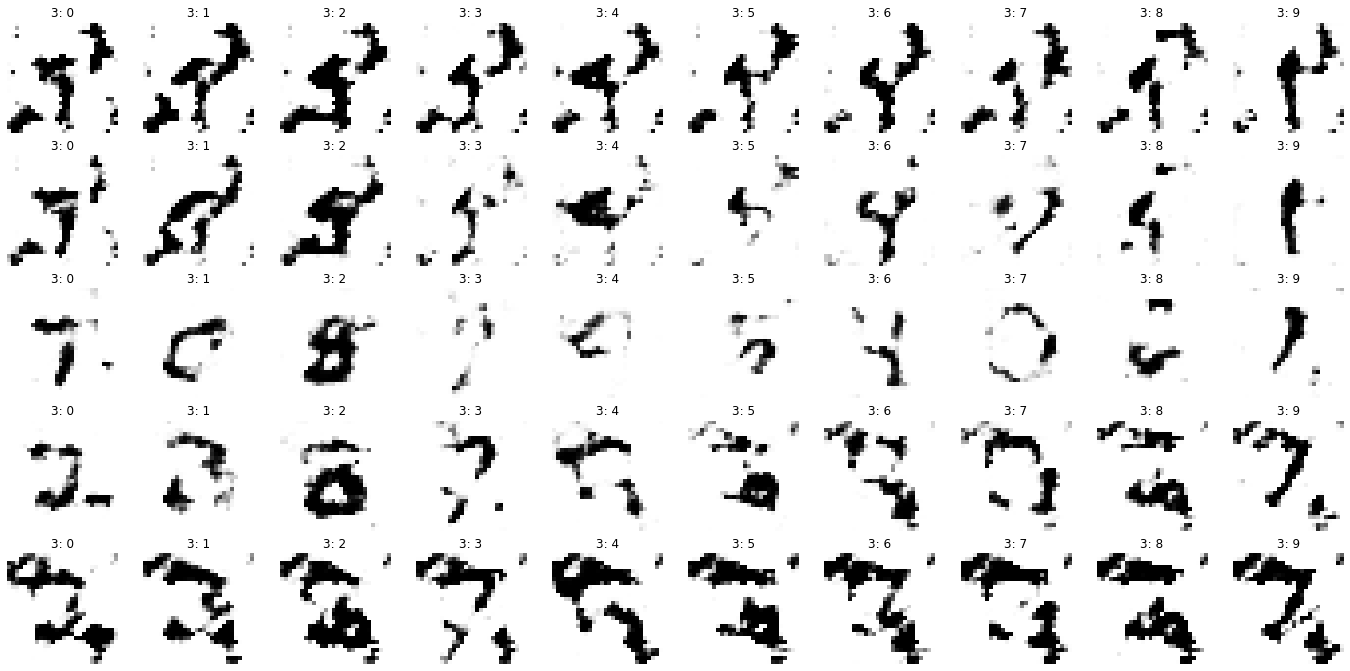

1: 100/100 


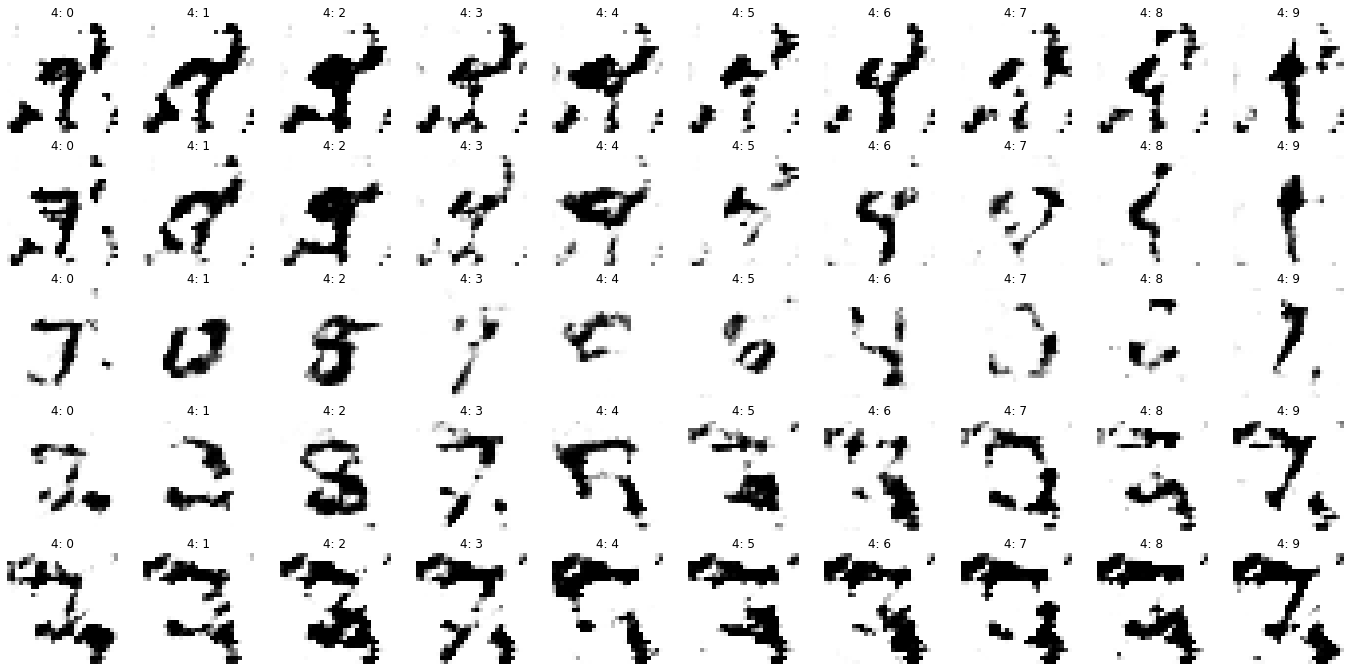

1: 100/100 


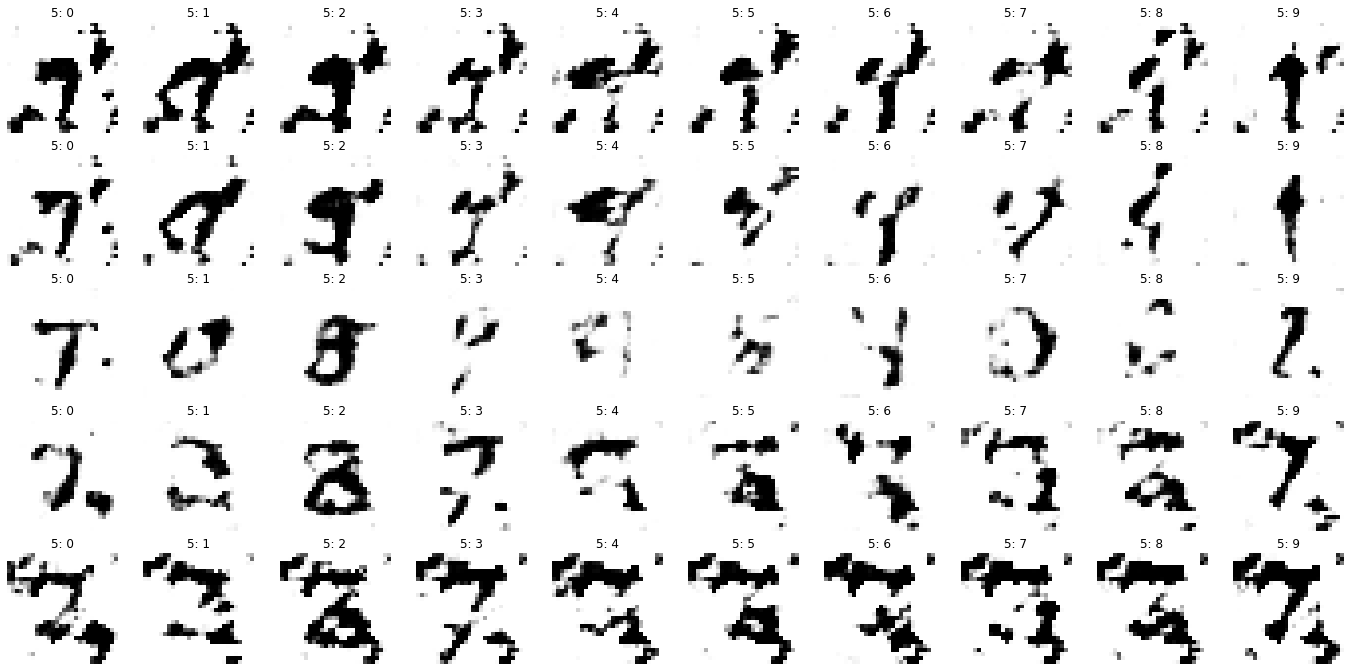

1: 100/100 


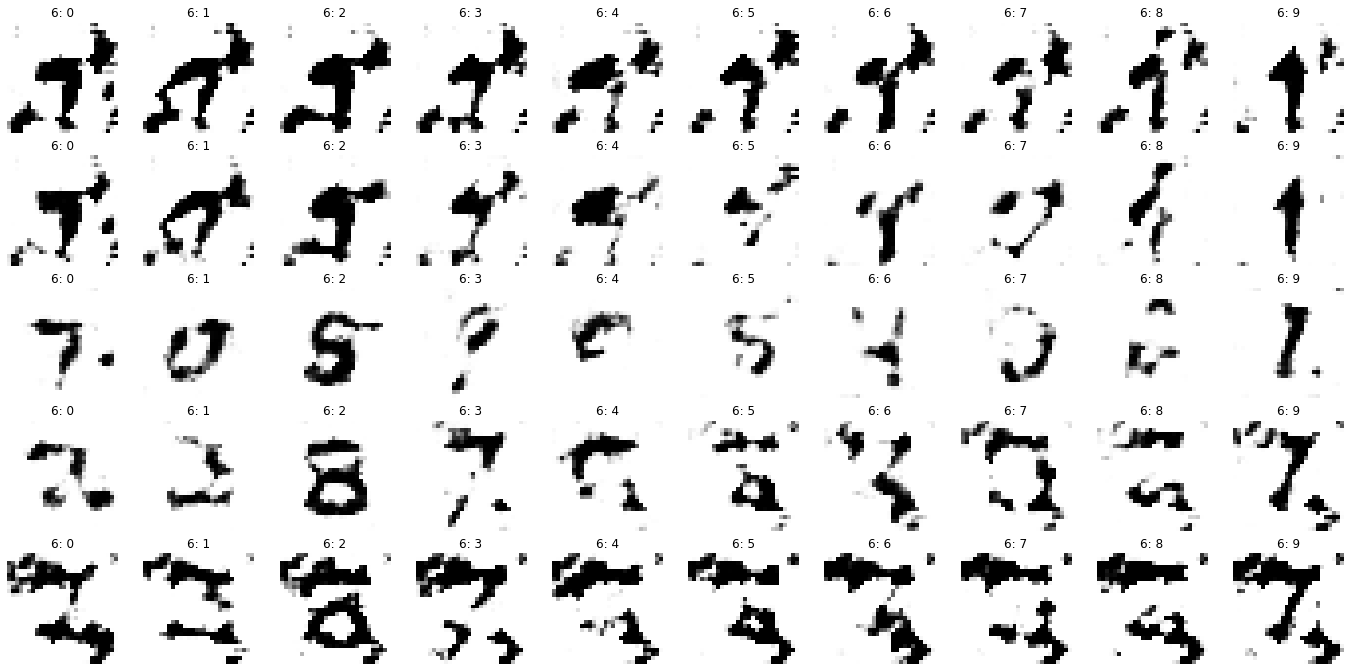

1: 100/100 


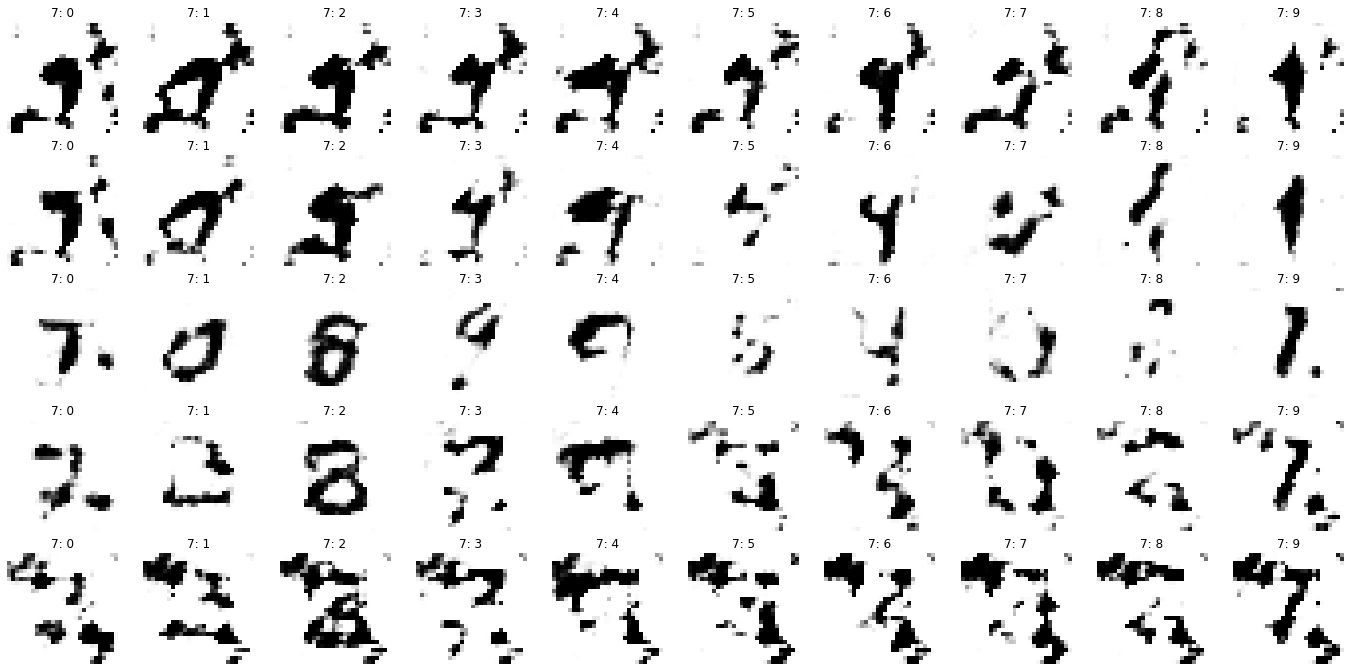

1: 100/100 


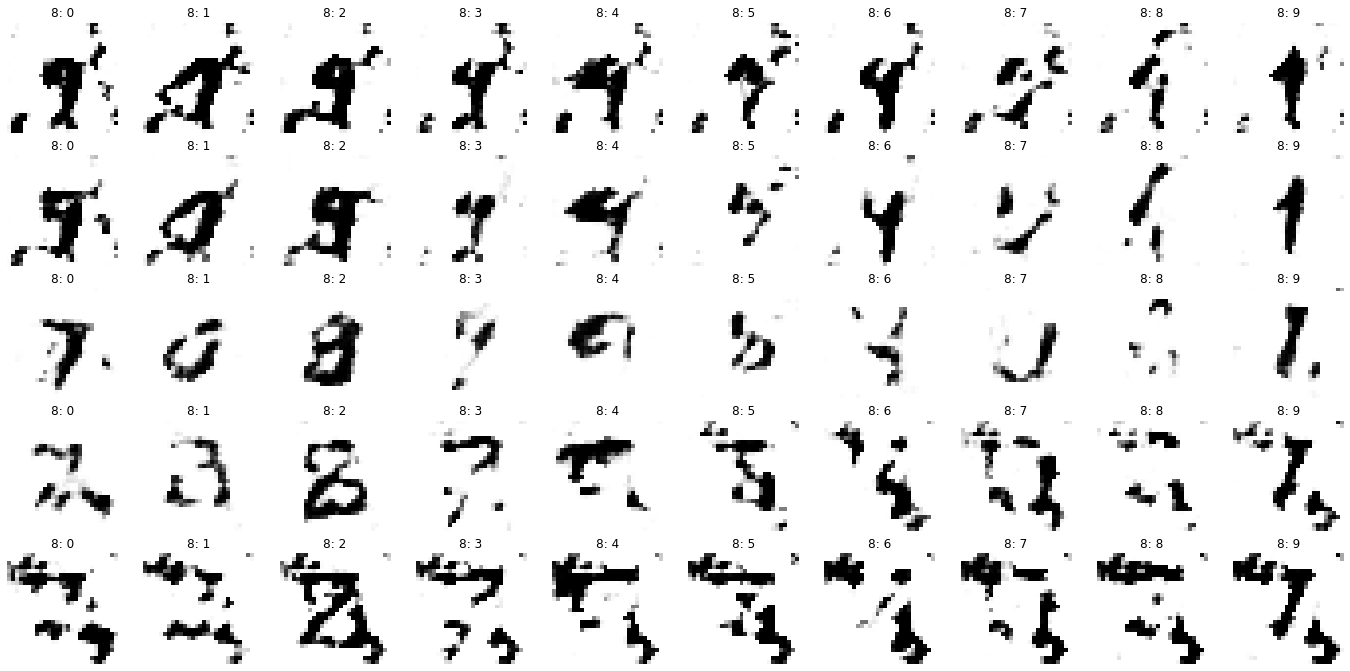

1: 100/100 


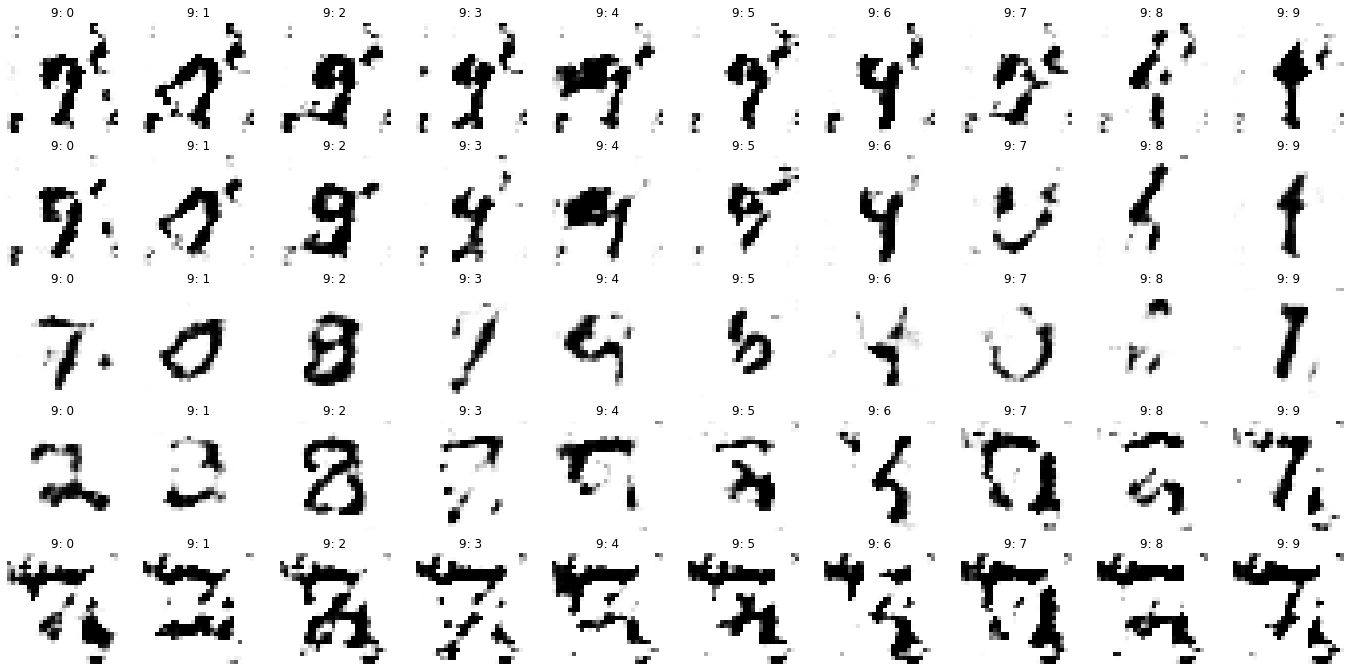

1: 100/100 


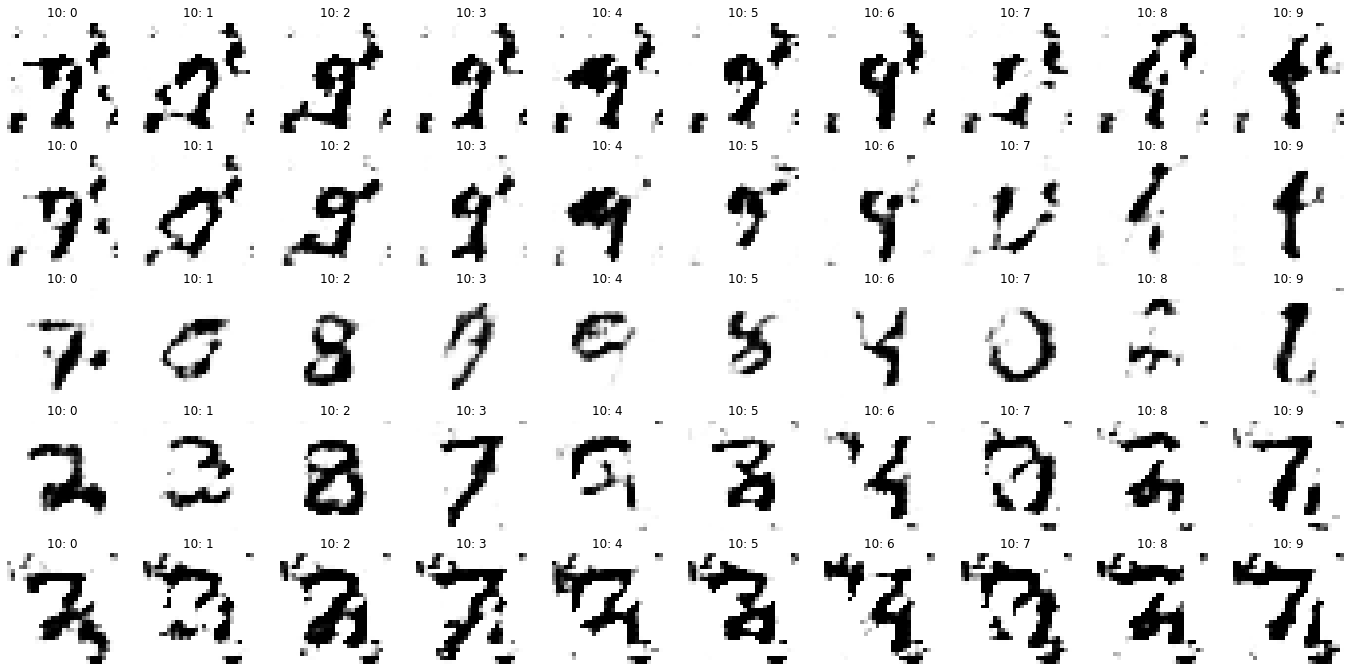

1: 100/100 


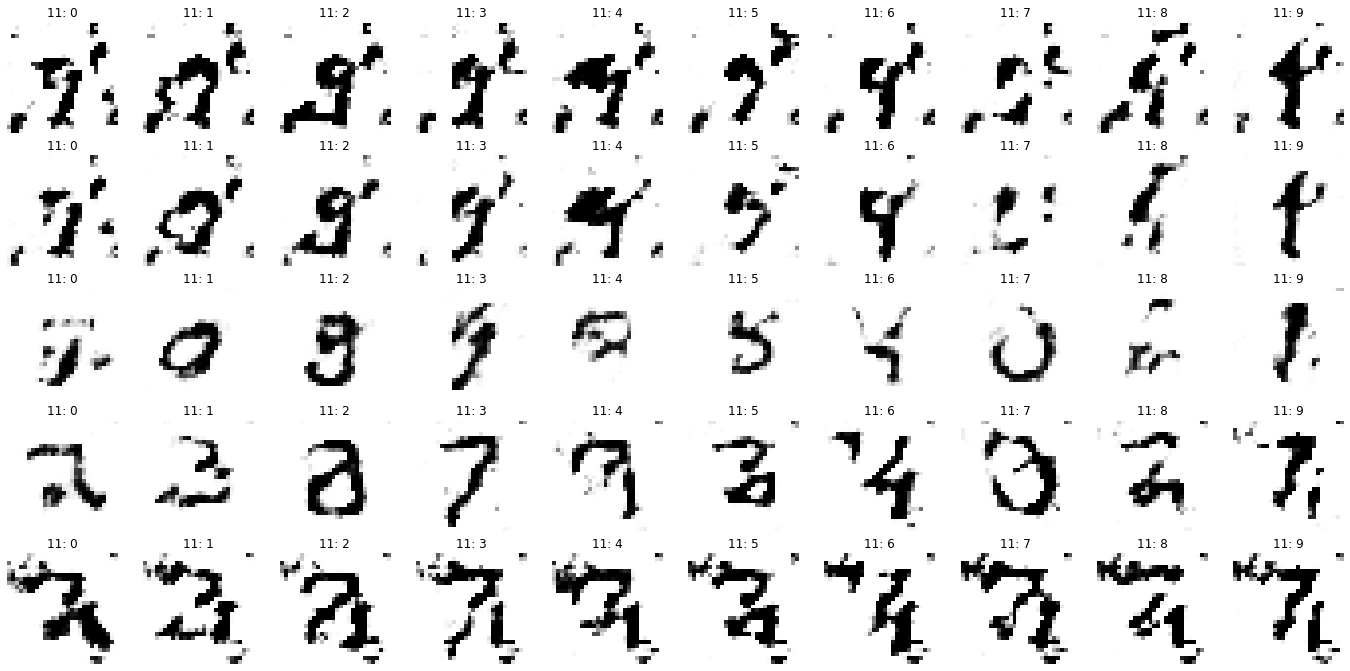

1: 100/100 


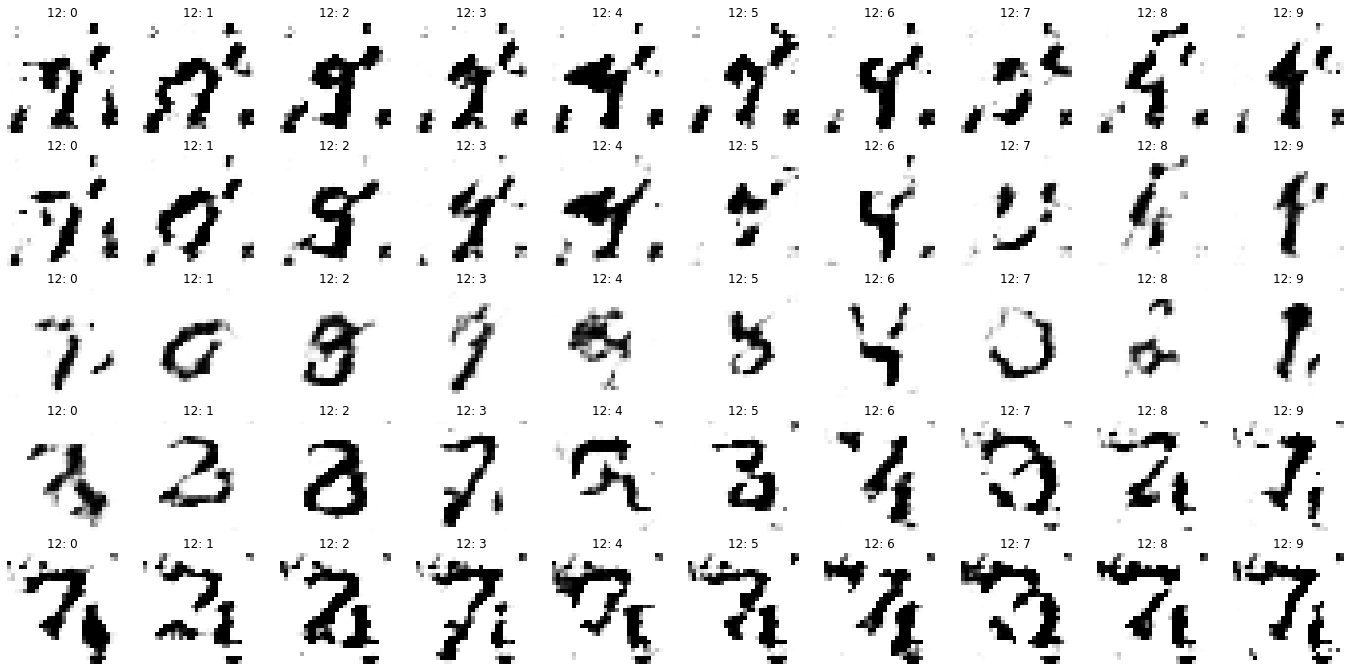

1: 100/100 


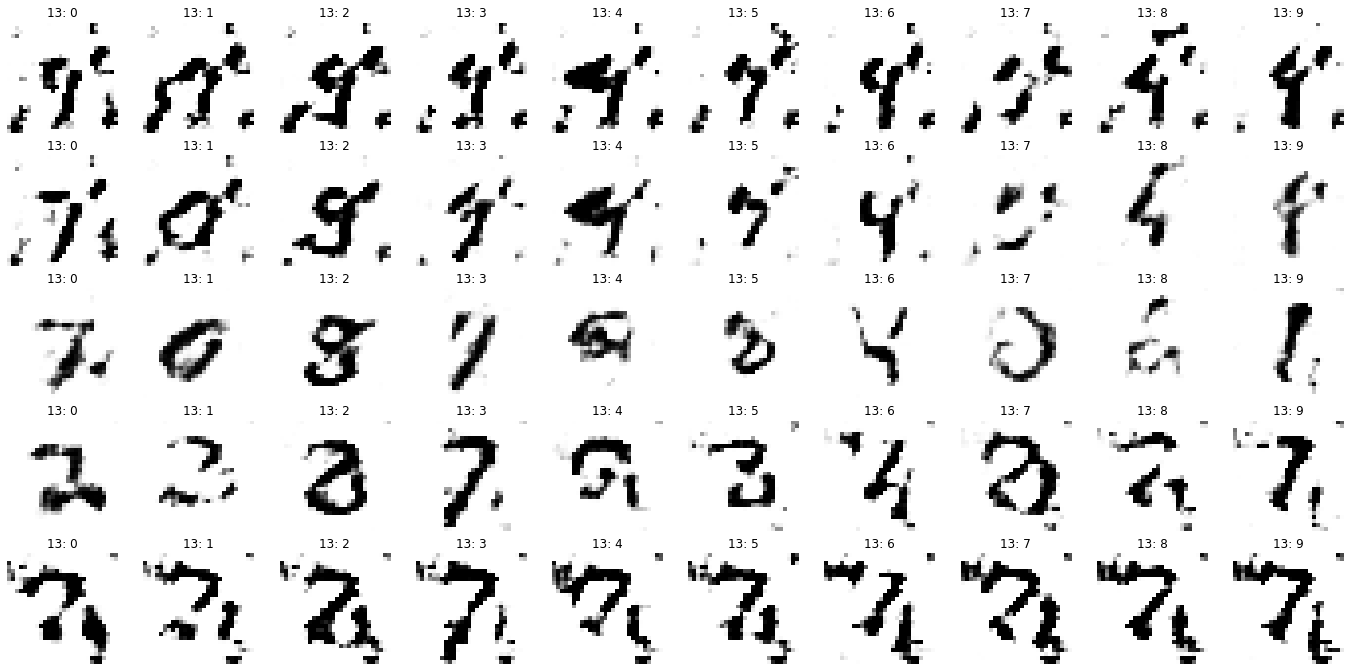

1: 100/100 


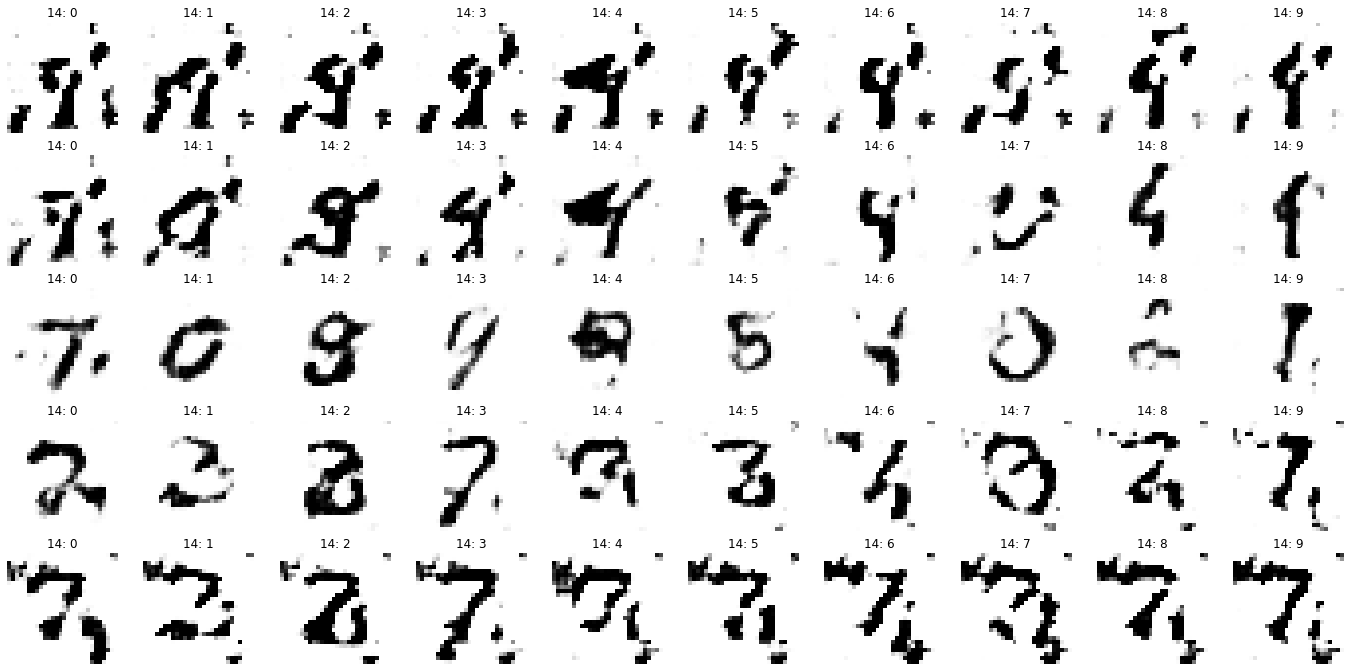

1: 100/100 


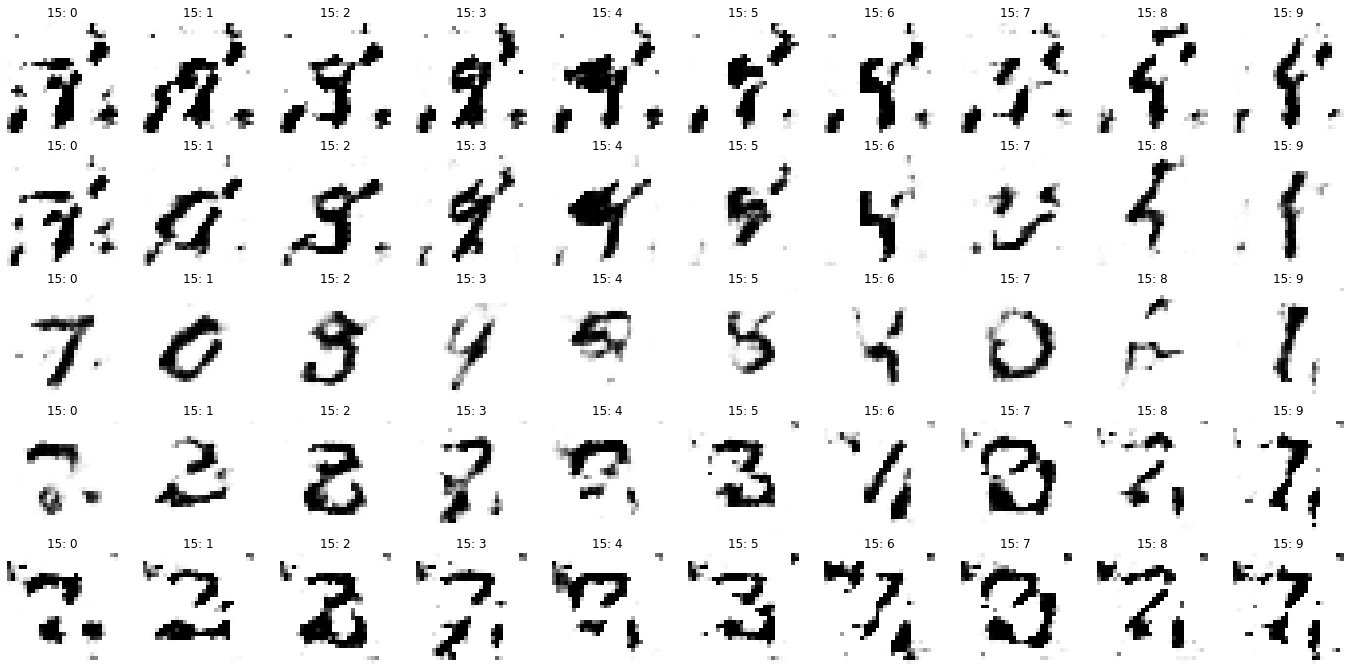

1: 100/100 


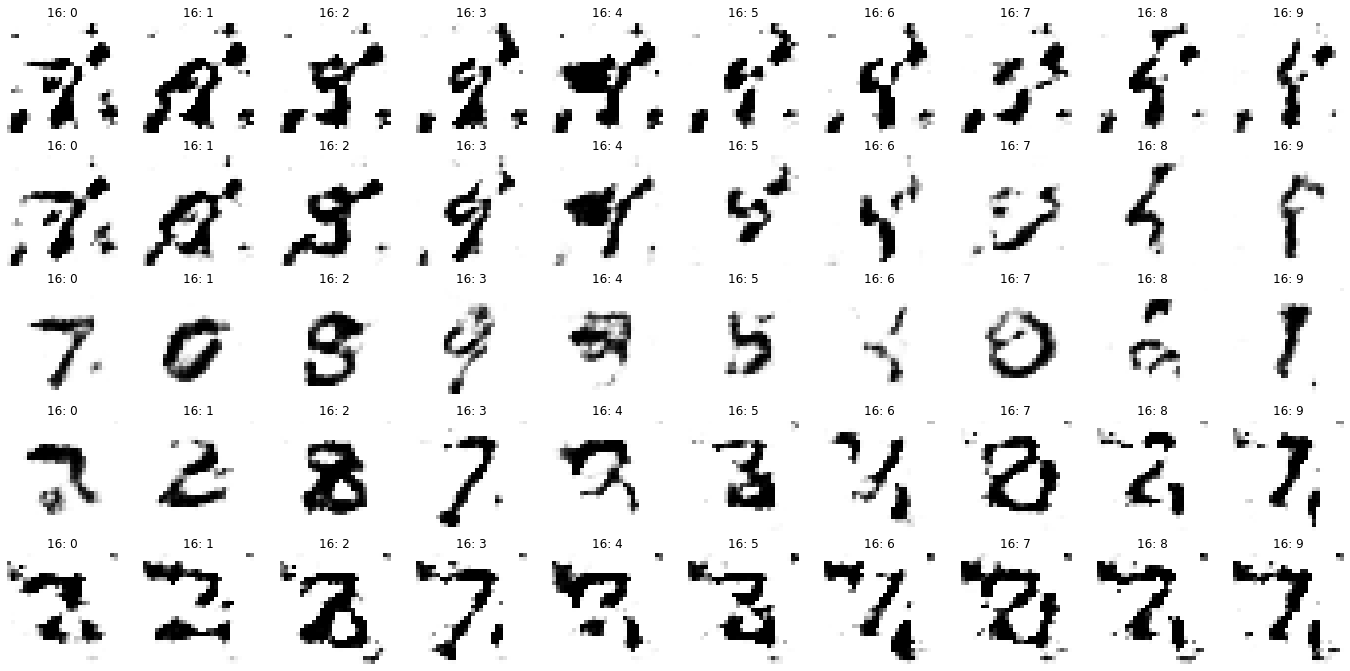

1: 40/100 

KeyboardInterrupt: 

In [65]:
infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=1e-4,
    glr=2e-4,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
print(name)
print(f'{name} 10.h5')
mnistTrainPlot(
    infogan1,
    epochs = 20,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)
gen = load_model((f'{name} 10.h5'))
for i in range(10):
    seed = 1050 + i
    plotc1(gen, seed=seed, titleStart = f'{seed} ')